## Team Lead comments

<div class="alert alert-block alert-success">

Thank you so much for your amazing work! It was a pleasure to review - really strong analysis. I am amazed by the depth of your analytical thinking, you did what almost no one does - you compared the project to real life, you digged into other sources, this is what makes you unique and a great DA! 

</div>

In [3]:
#required to write to excel file format from the Practikum platform
!pip install openpyxl

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 242 kB 928 kB/s eta 0:00:01
  Created wheel for et-xmlfile: filename=et_xmlfile-1.0.1-py3-none-any.whl size=8915 sha256=99fab0edbee0c0c6d423db196647d292876e9a57171716040a2bccc2225b35f0
  Stored in directory: /home/jovyan/.cache/pip/wheels/e2/bd/55/048b4fd505716c4c298f42ee02dffd9496bb6d212b266c7f31
Successfully built et-xmlfile


In [4]:
import pandas as pd
import numpy as np
from IPython.core.display import HTML, display
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
from functools import reduce
import seaborn as sns
import plotly.offline as pyoff
import plotly as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import math as math
import scipy 
from scipy import stats as st

In [110]:
class style:
    BOLD = '\033[1m'
    END ='\033[0m'
    BRED = '\u001b[31;1m'
    BBLUE ='\u001b[34;1m'
    SBLUE ='\u001b[38;5;39m'
    DBLUE ='\u001b[38;5;30m'
    ORANGE ='\u001b[38;5;208m'

In [81]:
#colored markdown cell for noted section
inf = "<style>div.info { background-color: #fcf2f2;border-color: #dFb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;}</style>"
HTML(inf)

<font color='#15317E'><h3>Overview</h3>
<font color='#2B547E' font size=3>
The purpose of this analysis is to ferret out the ineffective operators from this virtual telephony enterprise. Operator data is contained in the calls dataset, which will be analyzed. Metrics by which the operators will be measured will be determined and analyzed. The operators will be grouped into segments based on their performance on these metrics and relative performance evaluated based on these segments. Operator performance will be analyzed in the context of the time frame in which the data was gathered.

Tableau dashboard visualizing <br>
Telephony Operator Metrics by Performance Segment<br></font>  </font>
[Direct link to the Dashboard](https://public.tableau.com/profile/lcodyb#!/vizhome/VirtualTelephonyOperatorAnalysis/VirtualTelephonyOperators)

<p style="font-size:17px"> There are two related datasets: clients and calls. There will be an initial overview of the datasets in this section.

In [6]:
clients=pd.read_csv('telecom_clients_us.csv', parse_dates=['date_start'])

In [5]:
clients.shape

(732, 3)

In [6]:
display(clients.sample(3))

,user_id,tariff_plan,date_start
359,166621,C,2019-08-12
670,168449,B,2019-10-25
654,166560,B,2019-08-08


In [7]:
clients.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 732 entries, 0 to 731
Data columns (total 3 columns):
user_id        732 non-null int64
tariff_plan    732 non-null object
date_start     732 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 53.0 KB


In [133]:
calls=pd.read_csv('telecom_dataset_us.csv')

In [4]:
calls.shape

(53902, 9)

In [10]:
calls.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null object
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), float64(1), int64(4), object(3)
memory usage: 11.1 MB


In [11]:
display(calls.sample(3))

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
19069,166983,2019-10-12 00:00:00+03:00,out,False,901880.0,True,9,0,242
53154,168366,2019-11-03 00:00:00+03:00,in,False,NaN,True,1,0,4
35074,167521,2019-11-13 00:00:00+03:00,in,False,919794.0,False,59,4134,5797


### <font color=#F87217>Overview Precis</font>
<p style="font-size:17px">  The calls dataset is Goliath next to the clients dataset.<br> 
    Interesting, less than half of the unique users in the clients table appear in the calls table.
    As the focus of our entire inquiry is operators, users and their start dates are not relevant to the performance of virtual operators. <br>
    Initially it made sense to analyze the relative tariff plan shares of calls, but when we discovered that there is no difference to the bottom line between any of the three tariffs, then that line of inquiry seemed pointless as well.<br> 
    The date column in the calls dataset bears looking into as one means to pare down down the dataset volume. First off, it can be typed as datetime. My hunch at this stage is that the hours:minutes:seconds and UTC offset in the date records is exactly the same for all the records, which obviates the necessity for this level of detail.<br>
    The other notable fact at first glance in the calls dataset is the preponderance of nulls for operator_id: the very subject of our analysis! 

<font color='#15317E'><h3>Data Preprocessing</h3>

In [26]:
#checking that the hours-minutes_seconds and UTC offset are the same for each and every record
calls.date.value_counts().head(1)

2019-11-25    1220
Name: date, dtype: int64

In [134]:
#converting date to datetime type as well as shedding the uniform hours-minutes-seconds and UTC offset details
calls.date=pd.to_datetime([date for date, _ in calls.date.str.split()])

In [47]:
calls.sample()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
49298,168187,2019-11-22,out,False,937868.0,False,7,3051,3229


In [135]:
#this parameter was using strings for True, False so it makes sense for it to be boolean
calls.internal=calls.internal.astype('bool')

In [21]:
#memory usage plummeted by nearly 7mb for the above two dtype changes!
calls.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53902 entries, 0 to 53901
Data columns (total 9 columns):
user_id                53902 non-null int64
date                   53902 non-null datetime64[ns]
direction              53902 non-null object
internal               53785 non-null object
operator_id            45730 non-null float64
is_missed_call         53902 non-null bool
calls_count            53902 non-null int64
call_duration          53902 non-null int64
total_call_duration    53902 non-null int64
dtypes: bool(1), datetime64[ns](1), float64(1), int64(4), object(2)
memory usage: 7.3 MB


In [41]:
#Ensuring there is a logical relationship between call duration time and the total column, adding wait time to duration time
calls.query('call_duration>total_call_duration')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration


In [43]:
#checking for nulls, duplicates, zeroes
clients[clients.isna().any(axis=1)]
for i in clients.columns: print(i, len(clients[i]==0))
clients[clients.duplicated()]

user_id 732
tariff_plan 732
date_start 732


,user_id,tariff_plan,date_start


In [63]:
#checking duplicates 
calls[calls.duplicated()].head()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration


In [136]:
#dropping duplicate rows
calls.drop_duplicates(inplace=True)

In [25]:
#aside from the two boolean parameters, the zeros in duration bear further investigation
for i in calls.columns: print(i, len(calls[calls[i]==0]))

user_id 0
date 0
direction 0
internal 36216
operator_id 0
is_missed_call 27436
calls_count 0
call_duration 13831
total_call_duration 863


In [56]:
#examiningnulls
calls[calls.internal.isna()]
#checking for overlapping nulls
calls[calls.internal.isna()].shape[0]-calls[calls.internal.isna()]['operator_id'].value_counts().sum()

57

In [10]:
#ascertaining low % of internal calls
calls[calls.internal==1].count()/calls[calls.internal==0].count()

user_id                0.130572
date                   0.130572
direction              0.130572
internal               0.130572
operator_id            0.147173
is_missed_call         0.130572
calls_count            0.130572
call_duration          0.130572
total_call_duration    0.130572
dtype: float64

In [7]:
calls[calls.internal.isna()&calls.call_duration>0].sample()#32 records and operator ID is not null!

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
29912,167264,2019-11-21,in,NaN,919552.0,False,1,55,80


In [137]:
#filling the three dozen nulls with call duration that have operator id with the value that appears 87% of the time
calls.loc[calls.internal.isna()&(calls.call_duration>0),'internal'] = False

In [26]:
calls[calls.internal.isna()].sample()# for all the remainder, operator id is null!

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
37580,167626,2019-10-18,in,NaN,NaN,True,2,0,4


In [32]:
print(calls[calls.operator_id.isna()].shape[0])
calls[calls.operator_id.isna()].shape[0]/calls.shape[0]

7456


0.15215705481408923

In [13]:
#a df for comparing the null-filled original df with the df after eliminating nulls
initial=pd.read_csv('/datasets/telecom_dataset_us.csv')
initial.drop_duplicates(inplace=True)

In [49]:
initial[initial.operator_id.isna()].describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,7456.000000,0.0,7456.000000,7456.000000,7456.000000
mean,167259.123793,NaN,14.024142,66.749598,236.959496
std,586.842979,NaN,81.785240,945.349645,1265.307052
min,166377.000000,NaN,1.000000,0.000000,0.000000
25%,166782.000000,NaN,1.000000,0.000000,7.000000
50%,167125.000000,NaN,2.000000,0.000000,35.000000
75%,167727.000000,NaN,7.000000,0.000000,115.000000
max,168606.000000,NaN,2168.000000,26175.000000,42667.000000


In [21]:
initial[initial.operator_id.isna()&initial.call_duration>0].describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,55.000000,0.0,55.000000,55.000000,55.000000
mean,167959.654545,NaN,7.890909,4114.418182,4178.145455
std,581.656995,NaN,11.270533,6363.974599,6436.639241
min,166503.000000,NaN,1.000000,5.000000,16.000000
25%,168252.000000,NaN,1.000000,140.000000,158.500000
50%,168252.000000,NaN,2.000000,951.000000,967.000000
75%,168252.000000,NaN,11.000000,5916.000000,6070.000000
max,168336.000000,NaN,52.000000,26175.000000,26347.000000


In [25]:
initial[(initial.call_duration>0)&(initial.user_id==168252)].operator_id.nunique()#28
initial[(initial.call_duration>0)&(initial.user_id==168252)].count()
initial[(initial.call_duration>0)&(initial.user_id==168252)&(initial.operator_id.isna())].describe()

,user_id,operator_id,calls_count,call_duration,total_call_duration
count,83.0,0.0,83.000000,83.000000,83.000000
mean,168252.0,NaN,11.144578,5931.987952,6014.710843
std,0.0,NaN,12.898414,6783.096294,6849.794465
min,168252.0,NaN,1.000000,46.000000,54.000000
25%,168252.0,NaN,2.000000,656.500000,664.000000
50%,168252.0,NaN,5.000000,3225.000000,3287.000000
75%,168252.0,NaN,15.000000,8071.500000,8297.000000
max,168252.0,NaN,52.000000,26175.000000,26347.000000


In [48]:
initial.describe(include='all')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
count,49002.000000,49002,49002,48892,41546.000000,49002,49002.000000,49002.000000,49002.000000
unique,NaN,119,2,2,NaN,2,NaN,NaN,NaN
top,NaN,2019-11-25 00:00:00+03:00,out,False,NaN,False,NaN,NaN,NaN
freq,NaN,1109,28999,43239,NaN,27549,NaN,NaN,NaN
mean,167294.892759,NaN,NaN,NaN,916523.315409,NaN,16.462777,866.282091,1156.558202
std,598.558965,NaN,NaN,NaN,21230.041008,NaN,63.604098,3775.503352,4451.473661
min,166377.000000,NaN,NaN,NaN,879896.000000,NaN,1.000000,0.000000,0.000000
25%,166782.000000,NaN,NaN,NaN,900790.500000,NaN,1.000000,0.000000,46.000000
50%,167158.000000,NaN,NaN,NaN,913938.000000,NaN,4.000000,37.000000,208.000000
75%,167819.000000,NaN,NaN,NaN,937708.000000,NaN,12.000000,570.000000,901.000000


In [42]:
calls.head(3)

,index,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
0,1,166377,2019-08-05,out,True,880022.0,True,3,0,5
1,2,166377,2019-08-05,out,True,880020.0,True,1,0,1
2,3,166377,2019-08-05,out,True,880020.0,False,1,10,18


In [138]:
#focusing df for analysis on known operator_ids
calls=calls.dropna().reset_index(drop=True)
calls.describe(include='all')

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
count,41546.000000,41546,41546,41546,41546.000000,41546,41546.000000,41546.000000,41546.000000
unique,NaN,118,2,2,NaN,2,NaN,NaN,NaN
top,NaN,2019-11-25 00:00:00,out,False,NaN,False,NaN,NaN,NaN
freq,NaN,988,28813,36161,NaN,27436,NaN,NaN,NaN
first,NaN,2019-08-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2019-11-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,167301.311992,NaN,NaN,NaN,916523.315409,NaN,16.900424,1009.769172,1321.592813
std,600.418838,NaN,NaN,NaN,21230.041008,NaN,59.749373,4064.106117,4785.978633
min,166377.000000,NaN,NaN,NaN,879896.000000,NaN,1.000000,0.000000,0.000000
25%,166782.000000,NaN,NaN,NaN,900790.500000,NaN,1.000000,0.000000,67.000000


### <font color=#F87217>Assessing the role of nulls in this dataset</font>
<p style="font-size:17px"> 
A significant share, 15%, of the data consists of null operator values. On the one hand, you can see valuable information in call count, duration and missed calls for these null records.<br>
<br>
On the other hand, all of those details do not point to specific operators. Moreover, their inclusion would have an impact on assessment of success/failure for existing operators.<br>
<br>
So no matter what value would be assigned to fill in an operator's null, the addition of the data from the other columns would alter the distribution of every other parameter in the dataset.<br>
<br>    
As it is, the distribution of call data skews far right. A quarter of operators handle 5 or less calls and a full half of operators handle 19 or less. So the addition of filled-null operators comprising 15% of the records in the dataset would have a significant impact on the assessment of actual, non-null operators. To give this broad impact to non-identifiable operators is not fair to the existing operators.

<p style="font-size:17px"> 
Moreover,
out of 7456 null operators, only 55! (less than 1%) have call durations. <br>
    <br>
And 41 out of those 55 are all call sessions from a single user_id! In its sessions with null operators, that user has call direction split evenly and has call durations and wait time all over the board, with high std. <br>
    <br>
All told, that user has 28 unique operators handling its overall 521 call sessions with operator_id. Given the active nature of this user, combined with such diverse behavior, it is not possible to narrow down the operator_id to fill in the missing values.<br>
    <br>
Dropping the null operators resulted in slightly more outgoing calls and 113 less missed calls.
Although the overall call count diminished, the mean call count remained essentially the same. <br>
    <br>
The primary impact eliminating the null operators, with such a preponderance of zero duration calls, had on the parameters was to elevate the call duration and wait time.

<font color='#15317E'><h3>Preliminary Date Evaluation</h3>

In [8]:
#when the assessment begins
calls.date.min()

Timestamp('2019-08-02 00:00:00')

In [10]:
#last date of assessment
calls.date.max()

Timestamp('2019-11-28 00:00:00')

In [27]:
# the least calls are at the beginning of the time period in the dataset
calls.date.value_counts().nsmallest()

2019-08-11 00:00:00+03:00    2
2019-08-04 00:00:00+03:00    4
2019-08-10 00:00:00+03:00    7
2019-08-02 00:00:00+03:00    8
2019-08-03 00:00:00+03:00    9
Name: date, dtype: int64

In [26]:
#the most calls are at the tail end of the time period in the dataset, which overlaps Thanksgiving holiday weekend
calls.date.value_counts().nlargest()

2019-11-25 00:00:00+03:00    1220
2019-11-28 00:00:00+03:00    1198
2019-11-21 00:00:00+03:00    1186
2019-11-27 00:00:00+03:00    1180
2019-11-22 00:00:00+03:00    1176
Name: date, dtype: int64

In [15]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')

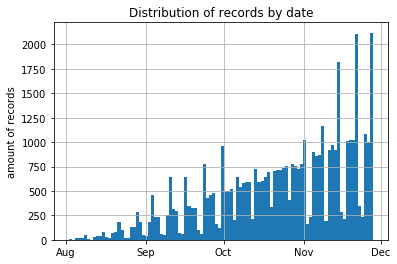

This distribution presents red flags!


In [16]:
#glance at the distribution over the entire time
ax=calls.date.hist(bins=100)
ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%b'))
ax.set_ylabel('amount of records')
ax.set_title('Distribution of records by date')
plt.show();
print(style.SBLUE+style.BOLD+"This distribution presents"+style.BRED+" red "+ style.SBLUE+ "flags!"+style.END)

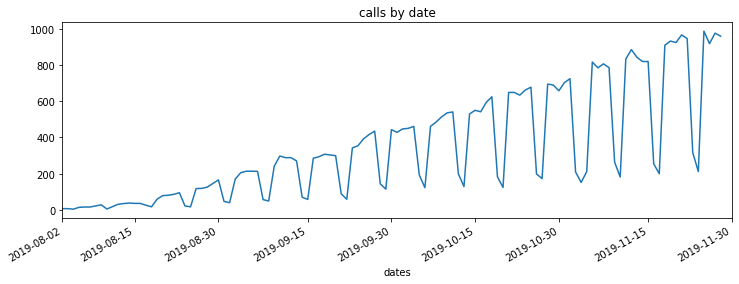

In [22]:
#a closer look at call by date
callsperdate=calls.groupby('date')['user_id'].count()
fig, ax = plt.subplots(figsize=(12, 4))
callsperdate.plot(ax=ax)
ax.set_xlabel('dates')
ax.set_title('calls by date')
ax.set_xticks(['2019-08-02','2019-08-15','2019-08-30','2019-09-15','2019-09-30','2019-10-15','2019-10-30','2019-11-15','2019-11-30'])
ax.set_xticklabels(['2019-08-02','2019-08-15','2019-08-30','2019-09-15','2019-09-30','2019-10-15','2019-10-30','2019-11-15','2019-11-30']);

In [139]:
#df for all non-missed calls with date + operator
datedf=calls[calls.is_missed_call==False].drop(
    ['user_id','direction','internal','is_missed_call','calls_count','call_duration','total_call_duration'],axis=1).reset_index(drop=True)

In [50]:
datedf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27436 entries, 0 to 27435
Data columns (total 2 columns):
date           27436 non-null datetime64[ns]
operator_id    27436 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 428.8 KB


### <font color=#F87217>Calls per date Interim Questions Raised</font>
<p style="font-size:17px"> 
This roller coaster distribution by date begs the following questions:<br>
<br>
Are the effective operators the ones that conduct calls on those scant days?<br>
Is it always the same operators that handle the low volume days?<br>
Which category of operators handles the down days? Does that differ from the category handling the nearby high volume days?<br>
<br>
After segmentation of operators, the above questions and more will be analyzed.

### <font color='skyblue'>A brief foray into the Clients table</font>

In [17]:
uniqueclients= clients.user_id.unique()
uniquecallers=calls.user_id.unique()
len(uniqueclients)#732
len(uniquecallers)#307withnulloperators,290without

290

In [64]:
len(uniquecallers)/len(uniqueclients)

0.39617486338797814

In [18]:
clientsnotincallersagain=set(uniqueclients).symmetric_difference(set(uniquecallers))
len(clientsnotincallersagain)#425withnulloperators, 442without

442

In [62]:
clients.tariff_plan.value_counts()

C    395
B    261
A     76
Name: tariff_plan, dtype: int64

### <font color='skyblue'>View to the Clients</font>
<p style="font-size:17px"> While it would ordinarily make sense to split the users by tariff plan and assess the difference in efficiency metrics segmented by tariff, in this case it does not, simply because we learned at the outset of this inquiry that the three tariff plans result in no difference to the bottom line.
<br><br>
So the primary data left to explore in the clients table concerns users. I compared the user list in the clients table with the user list in the calls table and discovered that 40 per cent of the unique users in the clients table are actively making calls.
<br>
Prior to removing null operators there were 17 more clients in the calls table. Now a full 442 of the clients are not yet making calls.
<br><br>
If this were an analysis of users, it would make sense to explore why certain users are making calls and others are not and to explore whether tariff or start date impacts their participation rate. However, this is analysis of operators, so that line of inquiry is not relevant.

<font color='#15317E'><h3>Closer Look at Parameters Effecting Operator Performance</h3>

<p style="font-size:17px">Beyond the unusual performance of operators by date, there are the criteria by which their performance must be measured. This section will look at the parameters measured in the dataset to understand operator performance overall to get a better sense of the range of performance from excellent to abysmal. 

<font color='orange'><p style="font-size:17px"><b> Wait Time</b></font>

In [140]:
calldifference=(calls.total_call_duration-calls.call_duration).to_list()
wait = pd.DataFrame(calldifference)
wait.columns = ['wait']
wait.head(2)

,wait
0,5
1,1


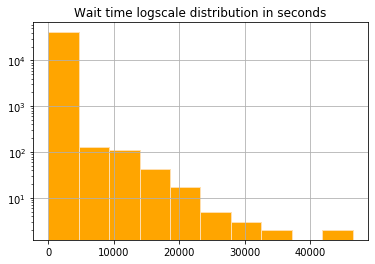

In [16]:
wait.hist(color='orange',log=True,ec='navajowhite')
plt.title('Wait time logscale distribution in seconds');

In [13]:
wait.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41491 entries, 0 to 41490
Data columns (total 1 columns):
wait    41491 non-null int64
dtypes: int64(1)
memory usage: 324.3 KB


In [72]:
calls.sample()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration
16883,167059,2019-09-16,in,False,911142.0,True,1,0,41


In [141]:
calls=pd.merge(calls,wait,left_index=True,right_index=True)

In [102]:
calls.head(3)

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,wait
0,166377,2019-08-05,out,True,880022.0,True,3,0,5,5
1,166377,2019-08-05,out,True,880020.0,True,1,0,1,1
2,166377,2019-08-05,out,True,880020.0,False,1,10,18,8


In [176]:
calls.wait.describe()

count    41546.000000
mean       311.823641
std       1175.373073
min          0.000000
25%         19.000000
50%         60.000000
75%        219.000000
max      46474.000000
Name: wait, dtype: float64

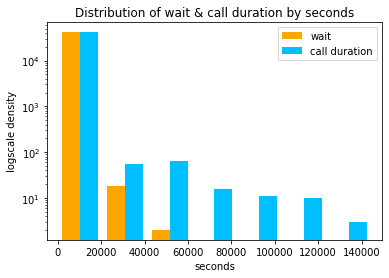

In [19]:
y1=calls.wait
y2=calls.call_duration
colors = ['orange','deepskyblue']
fig,ax1=plt.subplots()
ax1.hist([y1,y2],color=colors,log=True,bins=7)
ax1.set_ylabel('logscale density')
ax1.set_xlabel('seconds')
ax1.set_title('Distribution of wait & call duration by seconds')
ax1.legend(['wait','call duration']);

In [84]:
#examining the top quarter wait time
topquartwait=wait[wait.wait>219]
topquartwait.describe()

,wait
count,10365.000000
mean,1084.273034
std,2175.721815
min,220.000000
25%,322.000000
50%,526.000000
75%,1035.000000
max,46474.000000


In [101]:
wait[wait>wait.mean()].describe()

,wait
count,7975.000000
mean,1330.720376
std,2426.714045
min,312.000000
25%,443.000000
50%,688.000000
75%,1264.000000
max,46474.000000


In [62]:
#examining wait time for the top 1/16th (min 17 minutes)
topquartwait[topquartwait.wait>1035].describe()

,wait
count,2591.000000
mean,2930.829024
std,3775.711571
min,1036.000000
25%,1286.000000
50%,1672.000000
75%,2445.500000
max,46474.000000


In [71]:
#examining the wait time for the top nearly 2%
topquartwait[topquartwait.wait>2445].describe()

,wait
count,648.000000
mean,7101.483025
std,5780.517416
min,2446.000000
25%,3054.500000
50%,4457.000000
75%,9983.750000
max,46474.000000


In [64]:
#the top several outlier wait times
topquartwait[topquartwait.wait>9983].describe()

,wait
count,162.000000
mean,15226.160494
std,5738.752413
min,10109.000000
25%,11639.750000
50%,13390.500000
75%,16930.500000
max,46474.000000


<font color='orange'><p style="font-size:17px"><b> Wait Precis</b></font><br>
How long do callers wait before they hang up?<br>
"You often only get one shot at connecting with an inbound caller," according to Voice Response, Inc., which reports that "about 34% of callers who hang up won’t call back, ever." In a survey of corporate customers conducted by Talkdesk, 15% to a quarter of callers abandoned the call after waiting awhile.<br>
According to Talkroute, 15 seconds allows time for a call to connect. That means that the first quartile, up to 19 seconds, is within the realm of connection speed, namely excellent service. The median wait time of 60 seconds, is four-times as long as it takes to connect. That already feels like a wait, so not encouraging for callers. The 75% percentile falls at a 3.5 minute wait. Since wait time presents a right-skewed distribution with a mean more than five times as long as the median, the mean even exceeds the 75% mark. It is more than a more than 5 minute long wait.<br>
If we were examining anything besides operator efficiency, it would make sense to drop the nearly 2600 records (the 16th of records with the longest wait) waiting longer than 17 minutes, which, in general, isn't a very plausible wait time and surely the 75% quartile of that top 16th of records that waits about 41 minutes or longer, is an aberration. These records need to be kept in this case, because they form part of the spread on this measure of inefficiency.

<font color='crimson'><p style="font-size:17px"><b> Missed Calls</b></font>
<br>
What is the cost of a missed call?<br><br>
Research in 2019 from British Telecom estimated that one missed prospect call costs a business \\$1633 over a customer lifetime and that UK small businesses could be missing out on $123million dollars worth of business from missed calls.<br><br>
Depending on the market, missed calls be a significant revenue loss or boon. This section will further understand the missed call records in this dataset.

In [21]:
missedcalls=calls.loc[calls.is_missed_call==True]
missedcalls.shape[0]

14110

In [22]:
missedcalls.head()
datemissed=missedcalls.drop(['user_id','direction','internal','is_missed_call','calls_count','call_duration','total_call_duration','wait'],axis=1).reset_index(drop=True)

In [39]:
missedcalls.shape[0]/calls.is_missed_call.shape[0]

0.3396235498002214

In [18]:
missed0=missedcalls.loc[missedcalls.call_duration==0]
missed0.shape[0]

13814

In [19]:
missed0.shape[0]/missedcalls.shape[0]

0.9790219702338767

In [137]:
missedcalls.count()-missed0.count()

key_0                  296
user_id                296
date                   296
direction              296
internal               296
operator_id            296
is_missed_call         296
calls_count            296
call_duration          296
total_call_duration    296
wait                   296
dtype: int64

In [138]:
missedcalls.loc[missedcalls.call_duration==1].shape[0]

104

In [21]:
missed0.shape[0]/missedcalls.loc[missedcalls.call_duration<3].shape[0]

0.9920287253141831

In [139]:
morethan1=calls.loc[calls.calls_count>1]
print(morethan1.shape[0])
morethan1.loc[morethan1.is_missed_call==True].shape[0]

31056


10198

In [25]:
missedcalls.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14110 entries, 0 to 41543
Data columns (total 11 columns):
index                  14110 non-null int64
user_id                14110 non-null int64
date                   14110 non-null datetime64[ns]
direction              14110 non-null object
internal               14110 non-null bool
operator_id            14110 non-null float64
is_missed_call         14110 non-null bool
calls_count            14110 non-null int64
call_duration          14110 non-null int64
total_call_duration    14110 non-null int64
wait                   14110 non-null int64
dtypes: bool(2), datetime64[ns](1), float64(1), int64(6), object(1)
memory usage: 1.1+ MB


In [23]:
missedcallslast=missedcalls.loc[missedcalls.call_duration>5]

In [34]:
missedcallslast.describe()

,index,user_id,operator_id,calls_count,call_duration,total_call_duration,wait
count,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000,181.000000
mean,26129.558011,167578.640884,925717.988950,1.740331,130.541436,156.298343,25.756906
std,12313.915567,636.037253,19953.016268,1.334990,145.324979,145.485965,29.773339
min,1261.000000,166405.000000,884408.000000,1.000000,6.000000,11.000000,1.000000
25%,13008.000000,166916.000000,906408.000000,1.000000,43.000000,68.000000,6.000000
50%,27461.000000,167545.000000,933986.000000,1.000000,79.000000,103.000000,15.000000
75%,38774.000000,168252.000000,940630.000000,2.000000,147.000000,175.000000,35.000000
max,39980.000000,168336.000000,964666.000000,8.000000,741.000000,747.000000,265.000000


In [37]:
missedcallslast.user_id.value_counts().head(20)

168252    54
166916    34
167176    11
167264    11
168062    10
168187     7
167150     6
168091     5
167977     5
166503     4
168336     4
166837     4
167445     3
166732     3
166974     3
166485     2
166541     2
166997     2
167994     1
166405     1
Name: user_id, dtype: int64

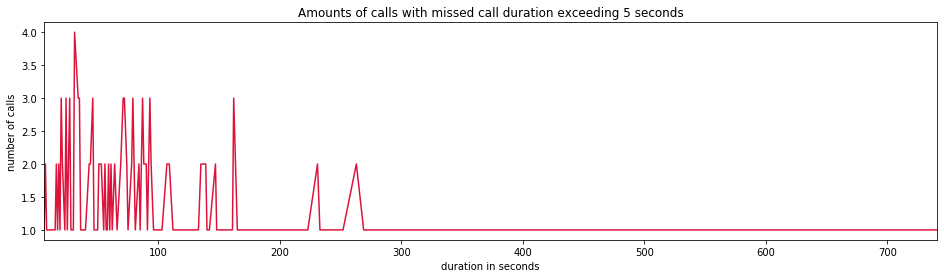

In [24]:
missedcallsgroupby=missedcallslast.groupby('call_duration')['user_id'].count()
fig, ax = plt.subplots(figsize=(16, 4))
missedcallsgroupby.plot(ax=ax,color='crimson')
ax.set_xlabel('duration in seconds')
ax.set_ylabel('number of calls')
ax.set_title('Amounts of calls with missed call duration exceeding 5 seconds');

<font color='crimson'><p style="font-size:17px"><b> Missed Call Summary</b></font>
<br>
In this dataset, with the duplicates and nulls removed, 34% of the call records are missed. 98% of missed calls have no duration time and another 1 percent have 1 or 2 seconds, representing technical errors when the call isn't connected.</font>
<br><br>
The 181 records with a longer than 5 second duration could be one of two things. They could be errors in the data. Under futher scrutiny, these records have a panapoly of users and operators as well as a realistic range of call count, duration and wait time. So I believe that these records are not errors but rather [deliberate missed calls](http://en.wikipedia.org/wiki/Missed_call) In many markets in countries worldwide, especially those where mobile phones with limited outgoing calls are used, calls are intentionally not completed/connected so as to avoid costs to the caller.<br><br>

<font size='4'>In fact,
<br>
1. Patterns of consecutive missed calls can mean certain messages: such as arriving at a destination and a package being ready for pick up<br>
<br>
2. Missed calls are used as marketing communication so that consumers can "miss call" specific numbers to receive a call or text back with advertising, product information or sponsored messages from actors, politicians and athletes.<br>
<br>
3. In one country, where missed calls in recent years have comprised as much as a quarter of all mobile calls, missed calls are an "economical and wide-reaching mechanism of communication," according to the Institute of Management in Kerala state.
<br><br>
4. Missed Called Marketing is the name of a field that describes this common practice. Entire companies specialize in it. One popular provider sends out cricket scores and organizing anti-corruption protests. In 2015 [Twitter acquired a missed call services provider](https://techcrunch.com/2015/01/19/twitter-confirms-acquistion-of-indias-missed-call-marketing-platform-zipdial/) for \\$20-\\$40 million dollars.<br>
<br>
5. Among other purposes, missed calls are used to check one's [bank balance](https://www.wsj.com/articles/BL-263B-7531), received tailored job listings, view program listings, hear on-demand soundtracks and vote in polls organized for viewers.
<br><br></p><p style="font-size:17px">
All of that is to say, the missed called records with duration can be legitimate uses of missed call services.
<br><br>
This project was delineated with three main areas of inefficiency. Missed calls will remain one area of inefficiency by which operators are scored.</p>

<font color='deepskyblue'><p style="font-size:17px"><b>Outgoing Calls</b></font>

In [14]:
calls.direction.describe()

count     41491
unique        2
top         out
freq      28813
Name: direction, dtype: object

In [25]:
calls[calls.direction=='out'].shape[0]/calls.direction.shape[0]

0.6935204351802821

In [38]:
calls[calls.direction=='out'].groupby('operator_id')['direction'].count().describe()

count    882.000000
mean      32.667800
std       38.145841
min        1.000000
25%        5.000000
50%       19.000000
75%       45.000000
max      228.000000
Name: direction, dtype: float64

In [67]:
calls[calls.direction=='out'].groupby('operator_id')['direction'].count(
).sort_values(ascending=False).head(3)

operator_id
901884.0    228
887276.0    198
901880.0    194
Name: direction, dtype: int64

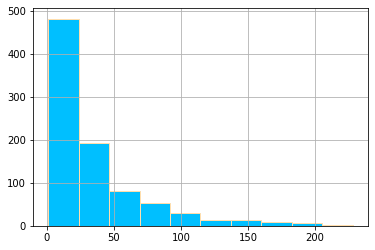

In [37]:
calls[calls.direction=='out'].groupby('operator_id')['direction'].count(
).sort_values(ascending=False).hist(ec='navajowhite',color='deepskyblue')

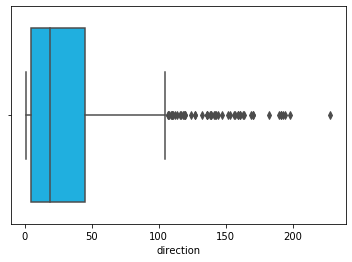

In [24]:
sns.boxplot(x=calls[calls.direction=='out'].groupby('operator_id')['direction'].count(),color='deepskyblue')

<font color='deepskyblue'><p style="font-size:17px"><b>Outgoing Calls Precis</b></font>
<br><br>
Nearly 70% of all calls are outgoing. The distribution for outgoing calls by operator_id is right-skewed, with most operators handling under 20 outgoing calls and a quarter of all operators handling less than 5. About one-tenth of the 882 operators who handle outgoing calls, 82, handle only 1 each. <br><br>
As far as leaders go, only 32 operators (3.6% of operators doing outgoing calls) handle more than 133 outgoing calls, seven-fold the median of 19.

<font color='#F87217'><p style="font-size:17px"><b>Per Operator Calls and Duration</b></font>

In [26]:
callsperoperator=calls.groupby('operator_id')['date'].count().to_frame().reset_index()
callsperoperator.rename(columns={
    'date':'calls_per_operator'},inplace=True)
callsperoperator=callsperoperator.sort_values(by='calls_per_operator',ascending=False)
callsperoperator.describe()

,operator_id,calls_per_operator
count,1092.000000,1092.000000
mean,925517.543956,38.045788
std,22854.532209,49.206403
min,879896.000000,1.000000
25%,906393.500000,5.000000
50%,925105.000000,19.000000
75%,944211.500000,50.000000
max,973286.000000,323.000000


In [27]:
callsperoperator.head(1)

,operator_id,calls_per_operator
204,901884.0,323


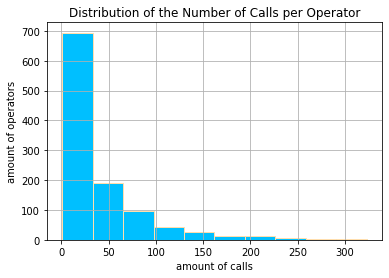

In [20]:
ax1=callsperoperator.date.hist(ec='navajowhite',color='deepskyblue')
ax1.set_title("Distribution of the Number of Calls per Operator")
ax1.set_ylabel("amount of operators")
ax1.set_xlabel("amount of calls");

In [27]:
callsperoperatoragg=calls.groupby('operator_id').agg({'direction':
                                     'count'}).reset_index()
callsperoperatoragg.rename(columns={
    'direction':'calls_per_op'},inplace=True)

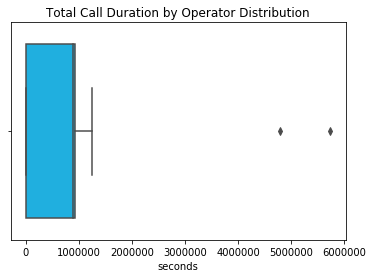

In [28]:
durationbyoperator=calls.groupby('operator_id').agg({'total_call_duration':
                                     'sum'}).reset_index()
durationbyoperator.rename(columns={
    'total_call_duration':'total_duration'},inplace=True)

sns.boxplot(x=durationbyoperator,color='deepskyblue')
plt.title("Total Call Duration by Operator Distribution")
plt.xlabel('seconds');

In [113]:
durationbyoperator.total_duration.nsmallest(109).head(1)

386    0
Name: total_duration, dtype: int64

In [99]:
durationbyoperator.total_duration.describe()

count    1.092000e+03
mean     5.028104e+04
std      2.391585e+05
min      0.000000e+00
25%      5.680000e+02
50%      6.674500e+03
75%      4.385675e+04
max      5.733237e+06
Name: total_duration, dtype: float64

In [94]:
durationbyoperator.total_duration.nlargest(10)

28     5733237
29     4783792
551    1252549
583     633196
958     493000
203     482797
582     474106
853     458915
12      431100
368     419807
Name: total_duration, dtype: int64

<font color='#F87217'><p style="font-size:17px"><b>Per Operator Calls and Duration Precis</b></font>
<p style="font-size:17px">
The distribution for calls by operator_id is right-skewed, with most operators handling under 20 outgoing calls and a quarter of all operators handling less than 5. (That portion of its distribution is precisely the same as that for outgoing calls.) 
<br><br>
One-eighth of the 1092 operators, 88, handle only 1 call each.
<p style="font-size:17px">
For leading operators, 64 (nearly 6%) handle more than 133 outgoing calls, seven-fold the median of 19.
    <br><br>
Duration by operator is right-skewed with the leading two operators holding values ten-fold as much of the other values in the top ten. And the rest of the values in the top ten are ten-fold as high as the 75% quartile.
<br><br>
The shortest duration tenth of operators have less than two minutes duration time each.

<font color='#15317E'><h3>Metrics: Measuring Efficiency for Operators</h3>

In [29]:
metrics=calls.groupby('operator_id').agg({'wait': 'sum',
                                          'is_missed_call': lambda x: (x%2!=0).sum(),
                                        'direction': lambda x: (x=='out').sum()}).reset_index()
metrics.rename(columns={
    'wait':'wait_total','is_missed_call':'missed_total','direction':'outgoing_total'}, inplace=True)

In [30]:
metrics=metrics.merge(callsperoperatoragg)
metrics=metrics.merge(durationbyoperator)

In [31]:
metrics['avgwait_percall']=metrics.wait_total/metrics.calls_per_op
metrics['avgduration_percall']=metrics.total_duration/metrics.calls_per_op

In [32]:
metrics['avgwaitshare']=metrics.avgwait_percall/metrics.avgduration_percall

In [33]:
metrics['wait_share']=metrics.wait_total/metrics.total_duration
metrics['miss_share']=metrics.missed_total/metrics.calls_per_op
metrics['out_share']=metrics.outgoing_total/metrics.calls_per_op

In [146]:
metrics.head(1)

,operator_id,wait_total,missed_total,outgoing_total,calls_per_op,total_duration,avgwait_percall,avgduration_percall,avgwaitshare,wait_share,miss_share,out_share
0,879896.0,12275,47,96,117,76137,104.91453,650.74359,0.161223,0.161223,0.401709,0.820513


In [145]:
metrics[metrics.isna().any(axis=1)]

,operator_id,wait_total,missed_total,outgoing_total,calls_per_op,total_duration,avgwait_percall,avgduration_percall,avgwaitshare,wait_share,miss_share,out_share
386,914626.0,0,1,1,1,0,0.0,0.0,NaN,NaN,1.0,1.0
874,946454.0,0,2,2,2,0,0.0,0.0,NaN,NaN,1.0,1.0
982,955068.0,0,1,1,1,0,0.0,0.0,NaN,NaN,1.0,1.0
1011,958458.0,0,1,1,1,0,0.0,0.0,NaN,NaN,1.0,1.0
1030,960674.0,0,1,1,1,0,0.0,0.0,NaN,NaN,1.0,1.0


In [34]:
metrics = metrics.fillna(0)

In [35]:
metrics.head(1)

,operator_id,wait_total,missed_total,outgoing_total,calls_per_op,total_duration,avgwait_percall,avgduration_percall,avgwaitshare,wait_share,miss_share,out_share
0,879896.0,12275,47,96,117,76137,104.91453,650.74359,0.161223,0.161223,0.401709,0.820513


In [42]:
metrics[metrics.isna().any(axis=1)]

,operator_id,wait_total,missed_total,outgoing_total,calls_per_op,total_duration,avgwait_percall,avgduration_percall,avgwaitshare,wait_share,miss_share,out_share


In [146]:
calls.sample()

,user_id,date,direction,internal,operator_id,is_missed_call,calls_count,call_duration,total_call_duration,wait
20660,167172,2019-10-29,out,False,904204.0,False,2,175,222,47


In [137]:
metrics.describe()

,operator_id,wait_total,missed_total,outgoing_total,calls_per_op,total_duration,avgwait_percall,avgduration_percall,avgwaitshare,wait_share,miss_share,out_share
count,1092.000000,1.092000e+03,1092.000000,1092.000000,1092.000000,1.092000e+03,1092.000000,1092.000000,1087.000000,1087.000000,1092.000000,1092.000000
mean,925517.543956,1.186358e+04,12.921245,26.385531,38.045788,5.028104e+04,216.086098,863.690513,0.270567,0.270567,0.315517,0.624152
std,22854.532209,6.451050e+04,18.394028,36.618762,49.206403,2.391585e+05,506.996689,1643.567435,0.206326,0.206326,0.230071,0.375333
min,879896.000000,0.000000e+00,0.000000,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.004010,0.004010,0.000000,0.000000
25%,906393.500000,1.387500e+02,1.000000,1.000000,5.000000,5.680000e+02,23.000000,109.626316,0.132188,0.132188,0.134685,0.333333
50%,925105.000000,1.008000e+03,5.000000,10.000000,19.000000,6.674500e+03,46.619048,295.436117,0.210923,0.210923,0.333333,0.714286
75%,944211.500000,7.692250e+03,18.000000,39.000000,50.000000,4.385675e+04,159.758929,838.229167,0.335935,0.335935,0.471362,1.000000
max,973286.000000,1.443002e+06,119.000000,228.000000,323.000000,5.733237e+06,5805.027397,20258.787986,1.000000,1.000000,1.000000,1.000000


<font color='#F87217'><p style="font-size:17px"><b>Metrics Precis</b></font><br><br>
To evaluate operator efficiency, key metrics must be aggregated.<br>
At first I compared key metrics on their own, but in order to put them on a more even ground with one another, I needed to find some way to put them on the same scale. <br>
The most clear cut way to do so was to turn them into a share of the total, so that now, each metric is a percentage of one hundred. <br>
Another benefit of relying on share to compare the various metrics is that using shares eliminates the wild deviation of the right-skewed distributions, while nonetheless incorporating the entire range of values at either end of the spectrum.
<br></br>
There were two different approaches to deriving share for wait time, going with its share of the total or taking average wait time per call first and both provided the same share figures. <br>
There were five records with no wait time and no call duration which resulted in a null wait share, so those nulls were replaced with zero.

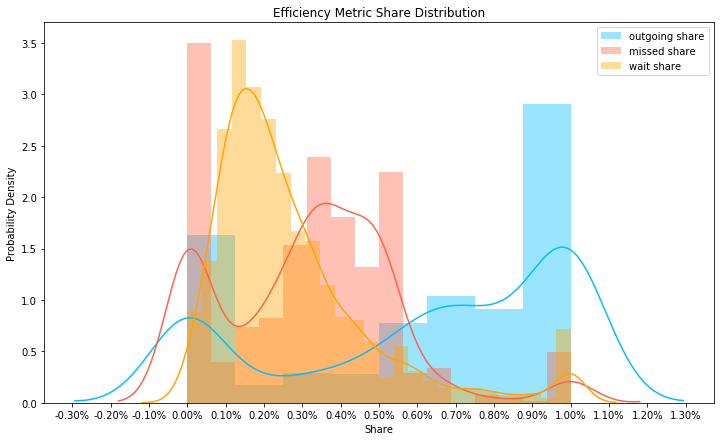

In [36]:
spacing=.1
plt.figure(figsize=(12,7))
axout=sns.distplot(metrics.out_share, label='outgoing share',color='deepskyblue')
axmiss=sns.distplot(metrics.miss_share, label='missed share',color='tomato')
axwait=sns.distplot(metrics.wait_share, label='wait share',color='orange')
plt.legend()
plt.title('Efficiency Metric Share Distribution')
plt.xlabel('Share')
plt.ylabel('Probability Density')
axout.xaxis.set_major_locator(ticker.MultipleLocator(spacing))
axout.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
axout.xaxis.set_major_formatter(PercentFormatter())
plt.show();

<font color='F9966B'><p style="font-size:17px"><b>Metric Share Distribution Summary</b></font><br><br>
All three efficiency metric shares are right skewed. <br>
The missed share peaks at 0, while the outgoing share peaks at 1. <br>
Wait share peaks at around its 25% quartile value of 13%.<br>
Outgoing share has a bimodal distribution, with missed share as a trimodal distribution.<br>
Wait share is the most normal distribution of the three metrics.
Nonetheless, the mean of missed share comes very close to its median of 33%. 

<font color='#15317E'><h3>Formulating Metrics Scores</h3>

In [203]:
metrics.columns

Index(['operator_id', 'wait_total', 'missed_total', 'outgoing_total',
       'calls_per_op', 'total_duration', 'avgwait_percall',
       'avgduration_percall', 'avgwaitshare', 'wait_share', 'miss_share',
       'out_share'],
      dtype='object')

In [37]:
#making a deep copy of the metrics df before eliminating several columns
metrics_initial=metrics.copy()

In [45]:
metrics=metrics.drop(['outgoing_total','avgwait_percall','avgduration_percall','avgwaitshare'],axis=1)
metricsout=metrics_initial.drop(['avgwait_percall','avgduration_percall','avgwaitshare'],axis=1)

In [137]:
print(metrics_initial.shape)
metrics.shape

(1092, 12)


(1092, 7)

In [138]:
metrics.head(1)

,operator_id,wait_total,calls_per_op,total_duration,wait_share,miss_share,out_share
0,879896.0,12275,117,76137,0.161223,0.401709,0.820513


In [39]:
np.percentile(metrics.out_share,range(0,100,25))

array([0.        , 0.33333333, 0.71428571, 1.        ])

In [46]:
#the first highest integer that results in the 75% quartile differing from the 100% value
out_share_bin=np.percentile(metrics.out_share,range(0,100,23))
out_share_bin=np.where(out_share_bin==0,-.01,out_share_bin)
out_share_bin

array([-0.01      ,  0.27272727,  0.67507674,  0.98579491,  1.        ])

In [222]:
np.percentile(metrics.miss_share,range(0,100,25))

array([0.        , 0.13468468, 0.33333333, 0.47136223])

In [223]:
np.percentile(metrics.wait_share,range(0,100,25))

array([0.        , 0.1314711 , 0.21039793, 0.33533635])

In [47]:
o_labels = range(1, 5)
w_labels = range(4,0,-1)
m_labels = range(4,0,-1)
metrics['wait'] = pd.qcut(metrics.wait_share, q = 4, labels = w_labels)
metrics['miss'] = pd.qcut(metrics.miss_share, q = 4, labels = m_labels)
metrics['out'] = pd.cut(metrics.out_share, bins=out_share_bin, labels = o_labels)

In [48]:
metrics.sample(3)

,operator_id,wait_total,missed_total,calls_per_op,total_duration,wait_share,miss_share,out_share,wait,miss,out
1086,972408.0,45,1,2,245,0.183673,0.500000,1.000000,3,1,4
243,904372.0,68,0,2,113,0.601770,0.000000,0.000000,1,4,1
621,932498.0,5408,7,15,16445,0.328854,0.466667,0.933333,2,2,3


In [116]:
col=['miss','wait','out']
for i in col:
    x=metrics[i].value_counts()
    print('For the column',i,"value counts are\n",x)
    print()

For the column miss value counts are
 3    298
1    273
4    273
2    248
Name: miss, dtype: int64

For the column wait value counts are
 1    273
2    273
3    273
4    273
Name: wait, dtype: int64

For the column out value counts are
 4    339
1    252
3    251
2    250
Name: out, dtype: int64



<font color='#ff6347'><p style="font-size:17px"><b>Interim Metric Scoring Precis</b></font><br><br>
There are two metric scoring schemes here. <br>
At first metric shares are split into quartiles, or in the case of outgoing calls, near quartiles. <br>
The shares for wait and missed calls are low, but that is intentional, because of the high penalty businesses pay for long waits and missed calls. The low shares reflect the mean of less than one-third in each case.<br>
As value counts indicates above, the relative shares for each score are similar in the case of missed calls, the same in the case of wait and the same in the case of outgoing calls, except for the largest final quartile, reflecting the high median and overlap of the 75% quartile and the maximum.
<br>
<br><br>
The first metric scoring system sums up the three metrics, thereby giving all three equal weight.<br> 
The scores that combine the two worst quartiles for each of the metrics are deemed "inefficient."<br>
The scores that feature the two worst quartiles for two of the metrics and the second-best quartile for the third metric are deemed operators in the "danger zone". (It is also possible to fall in that category with two second-best quartile scores if the third metric is the worst metric.)<br>
The scores that have two marks in the top two quartiles, are marked "efficient".<br>  
Scores with one metric at the highest mark, combined with the other categories in either of the top two quartiles, is "super efficient."
<br><br>
The next metric scoring system is weighted.<br>
Outgoing calls are not given the same importance as wait and missed calls.<br>
And more scoring categories are created so that the telephony business can pinpoint an operator's relative strengths and weaknesses.<br>
<br>
In this scoring scheme, there are three inefficient categories, two danger categories, two efficient categories and two super efficient categories.<br><br>
All operators who have the lowest score in either the missing or wait categories are inefficient, regardless of their outgoing score.<br><br>
All operators who have the topmost metric for wait time and the top two categories for missed calls is ranked super efficient.
<br><br>
All operators who rank in the top two categories for missed calls and wait time are efficient.
<br><br>
All operators who rank 3 and 2 for either wait time or missed calls are in the danger tier. The two danger categories reflect that there is one ranking for operators with more alarming missed call amounts and anoother ranking for those with more alarming wait times.
<br><br>
The "inefficient but engaged" category reflects operators who have the one of the lowest possible scores for waiting or missed calls, but nonetheless have high scores for the other metrics. So they are "engaged" in one or two areas but failing on a key metric that makes them inefficient.
<br><br>
There are three categories that mention outgoing or incoming. In the case of inefficient operators, there are some with the worst scores in the key missing and wait metrics, who nonetheless have the highest shares of outgoing calls. They remain inefficient but do handle a large portion of outgoing calls. In the case of the best operators, with the best missed call and wait time ratings, there are some who handle the lowest amounts of outgoing calls and their tier names mention incoming.
<br><br>
Hypothesis testing below will indicate which of the two scoring schemes more definitively pinpoints groups with differing behavior.

In [50]:
#sum scoring function
def score(x):
    if x>=10:
        return "super efficient"
    elif x>=8 and x<10:
        return 'efficient'
    elif x>6 and x<8:
        return 'danger zone'
    else:
        return 'inefficient'

In [51]:
#weighted scoring function
def waitmissout(x):
    if x=='111':
        return "Inefficient"
    elif x in ('224', '114','124'):
        return "Inefficient outgoing"
    elif x in ('441'):
        return "Super efficent incoming"
    elif x in ('442','432','444','443','433','434'):
        return "Super efficient"
    elif x in ('341','431','331'):
        return 'Efficient incoming'
    elif x in ('342','332','333','343','344','334'):
        return 'Efficient'
    elif x in ('322','321','323','324'):
        return 'Missing: Danger'
    elif x in ('232','231','233','234'):
        return 'Waiting: Danger'
    elif x in ('314','423','414','424','144','422','242','413','134','244'):
        return 'Inefficient but engaged'
    else:
        return "Inefficient"

In [52]:
metrics['total']=metrics[['wait','miss','out']].sum(axis=1)
metrics['score']=metrics['total'].apply(score)

In [64]:
metrics['segment']=metrics['wait'].astype(str)+metrics['miss'].astype(str)+metrics['out'].astype(str)

In [79]:
metrics[metrics['segment']=='444'].describe()

,operator_id,wait_total,missed_total,calls_per_op,total_duration,wait_share,miss_share,out_share,total
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.0,17.0
mean,916848.705882,256.823529,0.058824,5.058824,6736.411765,0.052458,0.005348,1.0,12.0
std,24310.289015,491.640142,0.242536,5.561818,11646.710271,0.034923,0.022049,0.0,0.0
min,883898.000000,3.000000,0.000000,1.000000,63.000000,0.019697,0.000000,1.0,12.0
25%,897894.000000,12.000000,0.000000,1.000000,128.000000,0.030080,0.000000,1.0,12.0
50%,910926.000000,83.000000,0.000000,2.000000,1647.000000,0.033104,0.000000,1.0,12.0
75%,930524.000000,266.000000,0.000000,8.000000,9496.000000,0.079365,0.000000,1.0,12.0
max,969600.000000,2066.000000,1.000000,19.000000,48336.000000,0.125000,0.090909,1.0,12.0


In [81]:
metrics[metrics['segment']=='111'].describe()

,operator_id,wait_total,missed_total,calls_per_op,total_duration,wait_share,miss_share,out_share,total
count,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0
mean,913886.0,27.0,1.0,2.0,65.0,0.415385,0.5,0.0,3.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,913886.0,27.0,1.0,2.0,65.0,0.415385,0.5,0.0,3.0
25%,913886.0,27.0,1.0,2.0,65.0,0.415385,0.5,0.0,3.0
50%,913886.0,27.0,1.0,2.0,65.0,0.415385,0.5,0.0,3.0
75%,913886.0,27.0,1.0,2.0,65.0,0.415385,0.5,0.0,3.0
max,913886.0,27.0,1.0,2.0,65.0,0.415385,0.5,0.0,3.0


In [82]:
metrics[metrics['segment']=='114'].describe()

,operator_id,wait_total,missed_total,calls_per_op,total_duration,wait_share,miss_share,out_share,total
count,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.000000,104.0,104.0
mean,930149.653846,22922.625000,9.519231,17.721154,49561.365385,0.653122,0.676552,1.0,6.0
std,21539.646692,48726.682297,11.413653,21.977242,100627.519591,0.252337,0.215003,0.0,0.0
min,883018.000000,1.000000,1.000000,1.000000,1.000000,0.343221,0.473684,1.0,6.0
25%,919313.000000,36.250000,1.000000,2.000000,46.000000,0.424385,0.500000,1.0,6.0
50%,933064.000000,345.500000,3.000000,5.500000,467.000000,0.570979,0.535714,1.0,6.0
75%,945769.500000,29892.500000,14.250000,28.000000,65765.500000,1.000000,1.000000,1.0,6.0
max,973120.000000,356078.000000,49.000000,86.000000,633196.000000,1.000000,1.000000,1.0,6.0


In [99]:
metrics[metrics['total']>10].describe()

,operator_id,wait_total,missed_total,calls_per_op,total_duration,wait_share,miss_share,out_share,total
count,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000,26.000000
mean,920508.769231,375.423077,1.153846,9.038462,10194.884615,0.062211,0.058080,0.986538,11.653846
std,22779.499549,823.054272,2.880171,14.795893,24860.173010,0.043997,0.109216,0.052072,0.485165
min,883898.000000,3.000000,0.000000,1.000000,63.000000,0.019697,0.000000,0.750000,11.000000
25%,906465.500000,21.500000,0.000000,1.000000,360.750000,0.031735,0.000000,1.000000,11.000000
50%,920820.000000,99.000000,0.000000,4.000000,1733.500000,0.041701,0.000000,1.000000,12.000000
75%,931793.500000,264.500000,0.750000,9.500000,9142.750000,0.092599,0.068182,1.000000,12.000000
max,969600.000000,3850.000000,11.000000,72.000000,121868.000000,0.183908,0.333333,1.000000,12.000000


In [82]:
metrics[metrics['total']<6].describe()

,operator_id,wait_total,missed_total,calls_per_op,total_duration,wait_share,miss_share,out_share,total
count,42.000000,42.000000,42.000000,42.000000,4.200000e+01,42.000000,42.000000,42.000000,42.000000
mean,921881.952381,12548.666667,6.238095,15.404762,3.596517e+04,0.473681,0.439459,0.533506,4.714286
std,23502.147727,65473.269394,9.349082,23.586953,1.933302e+05,0.137562,0.123163,0.267169,0.507779
min,884408.000000,10.000000,1.000000,2.000000,1.200000e+01,0.265432,0.142857,0.000000,3.000000
25%,902056.500000,69.250000,2.000000,4.000000,1.635000e+02,0.381475,0.400000,0.447647,4.250000
50%,918973.000000,180.000000,2.000000,5.500000,4.720000e+02,0.430200,0.500000,0.563542,5.000000
75%,937416.500000,611.000000,6.000000,14.000000,1.496500e+03,0.558848,0.500000,0.750000,5.000000
max,970240.000000,423767.000000,41.000000,91.000000,1.252549e+06,0.833333,0.666667,0.944444,5.000000


<font color='lightskyblue'><p style="font-size:17px"><b>Tiered Metric Precis</b></font><br>
<p style="font-size:17px">
There are only 17 operators in the topmost tier, with scores of 444. Their total wait time is not overwhelmingly impressive. The mean wait time is more than 4 minutes and the median is one and a half minutes. The missed total count is impressive: most have 0 with a mean of .06. All calls are outgoing. Another not impressive statistic in this rarified grouping is calls per operator: the median is two, the mean 5. Their total duration is nearly half an hour for the median and nearly two hours for the mean. So as a portion of that entire duration, their wait time is scant: with a mean of 5% and a median of 3%. Even the highest weight share is 12.5%.
<p style="font-size:17px">
Only 1 operator has the dubious honor of ranking the worst at 111: with just two calls total, one is missed. The call that did go through lasted only a minute, of which 42% was spent waiting. <br>
    <br>
The biggest group of operators with a failed metric are those with all outgoing calls, 104. In fact, they comprise about one-tenth of all operators.
<br><br>
Altogether, their mean wait time comprised nearly half of their total duration. Their median total wait of five and three quarters minutes takes up most of their median total call duration of 7.8 minutes. Their wait share is 65% on average and 57% by the median. Missed calls were a similarly high share: 68% for the mean and 54% for the median. On average they missed 9.5 calls with 3 missed calls as a mean. The one area they shone was in calls per operator, with nearly 18 on average and 5.5 for the median.

<font color='#ff6347'><p style="font-size:17px"><b>Metric Score Precis</b></font><br>
<p style="font-size:17px">
There are only 26 operators with the highest of the four possible scores, with a total higher than 10. Their wait time is also not impressive. The mean total wait time is more than 6 minutes and the median a bit longer than one and a half minutes. The missed total count is impressive: most have 0 with a mean a shade over 1. All calls are outgoing. 
<p style="font-size:17px">
Calls per operator, while not stellar, is nonetheless double the amount of the top tier segment: in this scoring system, the median is four, the mean is 9. Their total duration is nearly half an hour for the median, same as the topmost tier, but in this case, for the top scorers, the mean total duration is much longer, altogether three hours. So as a portion of that entire duration, their wait time is minimal: a mean of 3.7% and a median of 6%. The highest wait share is triple the mean wait share of 6%. The median is only 4%.
<p style="font-size:17px">
42 operators have the lowest scores, 6 or less. Although their median total weight time of 3 minutes is about double that of the best operator score, their mean total weight time is 3.5 hours! Their missed total is six on average, two as median - half of their calls. They have the same median calls per operator, 5.5, as the lowest-performing operators by the tier segmentation but slightly less on average, 15. <br>
Although their average total duration amounts to a 10 hour total, on average 47% of that time is spent waiting. <br>The lowest tier and the lowest score operators share the same median total duration of just 7.8 minutes: those with the lowest score spend devote 43% of that duration to waiting and those in the lowest tier allocate a whopping 57% of the median duration time to waiting.

In [108]:
metrics['tier']=metrics['segment'].apply(waitmissout)

In [99]:
tier_count=metrics.tier.value_counts()
tier_count=tier_count.to_frame()
tier_count.columns=['operators']
tier_count

,operators
Inefficient,333
Inefficient but engaged,135
Inefficient outgoing,129
Super efficient,113
Efficient,100
Missing: Danger,76
Super efficent incoming,73
Waiting: Danger,72
Efficient incoming,61


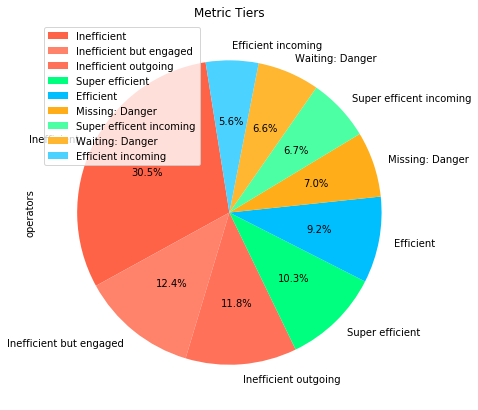

In [107]:
col=['#ff6347','#ff826b','#ff7259','springgreen','#00bfff','#ffae19','#4cffa5','#ffb732','#4cd2ff']
tier_count.plot.pie(figsize=(7, 7), autopct='%1.1f%%', shadow = False, startangle = 99, colors=col,subplots=True)
plt.title("Metric Tiers");

In [123]:
score_count=metrics.score.value_counts()
score_count=score_count.to_frame()
score_count.columns=['operators']
score_count

,operators
efficient,476
inefficient,288
danger zone,229
super efficient,99


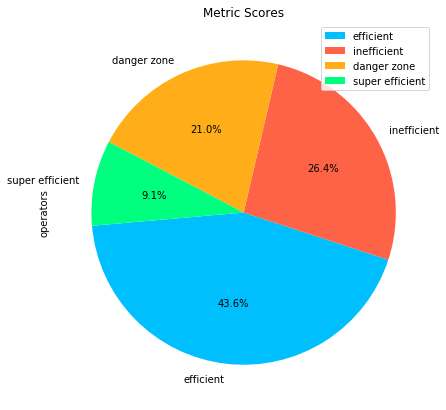

In [33]:
col=['#00bfff','#ff6347','#ffae19','springgreen']
score_count.plot.pie(figsize=(7, 7), autopct='%1.1f%%', shadow = False, startangle = 185, colors=col,subplots=True)
plt.title("Metric Scores");

<font color='#ffae19'><p style="font-size:17px"><b>Considering the Two Metric Scoring Schemes</b></font><br>
<p style="font-size:17px">
In the first grouping, by score sum, about 575 operators are efficient or super efficient, 229 are in the 'danger zone' and 288 are inefficient. In the second grouping, by manual sort into categories, 347 operators are efficient or super efficient, 148 are in the 'danger zone' and a whopping 597 are inefficient.
<p style="font-size:17px">
The primary reason for the difference is that the outgoing call share had an equivalent impact to the other two metrics in the score sum. But in the manual categorization, a successful outgoing call rate could not compensate for mediocre performance on the other metrics: those operators would still be categorized as ineffective.
    <p style="font-size:17px">
The categorization with more groupings sets a higher bar. The reason this could be necessary is that a long wait time or high missed call rate cannot be tolerated. So even if the outgoing call rate is acceptable or outstanding, that does not make a good operator out of one failing on wait time and missing calls. 
    <p style="font-size:17px">
Therefore, the results of the two scoring systems have the one main difference: the weighted system has 55% of operators classed as ineffective and the nonweighted sytem has nearly that same majority amount of efficient/super efficient operators. That gives it a whopping 20% more super or efficient operators than the weighted tally. There are more operators in the danger zone in the weighted scoring as well. <br><br><font color='#461B7E' font size=4>
Although, on first glance, it would seem that the segmentation with more categories and a greater emphasis on the wait time and missed call metrics would most clearly delineate poorly-performing operators, the quality of both segmentation schemes remains to be seen.</font> <br><p style="font-size:17px">
For that reason, I will compare the differences between segments in a series of statistical tests.<br>
The first comparison mixes the segmentation groups - culling only the operators that rank the best and the worst in both segmentation schemes.<br><p style="font-size:17px">
The next comparisons are between the tier categories. The first set of comparisons pits the efficient tier against the inefficient tiers. One comparison is with the inefficient tier that handles outgoing calls: the sample for the efficient tier and that inefficient outgoing tier are close in size. The other comparison is between the efficient tier and the general inefficient tier.<br><p style="font-size:17px">
The final tier comparisons are for the super efficient tiers against the efficient tier and then the inefficient tier. Then the danger tiers against the efficient tier and the inefficient tier.<br><br>
Next, there are statistical tests for the four scored groups.<br>
Efficient scored operator metrics are compared against inefficient, super efficient and danger zone scored operator metrics. Then danger zone operator metrics are compared against those scored inefficient.<br><br>
A tally of those test results will likely shed light on the ability of the two segmentation schemes to differentiate between operator performance categories.

<font color='deepskyblue'><p style="font-size:17px"><b>Preparing scored and tiered groupings for comparison and statistical testing</b></font><br>
<p style="font-size:17px">

In [159]:
#finding the highest performing operators in both scoring schemes
best = metrics[(metrics['score'] == 'super efficient') & (metrics['tier'] == 'Super efficient')]
bestops=best.operator_id.to_list()
bestarray=np.array(bestops)
len(bestops)

63

In [160]:
#finding the lowest performing operators in both scoring schemes
extremelybad=metrics[(metrics['score'] == 'inefficient') & (metrics['tier'] == 'Inefficient')]
extremelybadops=extremelybad.operator_id.to_list()
extremelybadopsarray=np.array(extremelybadops)
len(extremelybadops)

174

In [113]:
#creating lists of specific metrics to compare in statistical testing
extremelybad_duration=extremelybad.total_duration.to_list()
extremelybad_callamt=extremelybad.calls_per_op.to_list()
extremelybad_missed=extremelybad.missed_total.to_list()
extremelybad_wait=extremelybad.wait_total.to_list()

best_duration=best.total_duration.to_list()
best_callamt=best.calls_per_op.to_list()
best_wait=best.wait_total.to_list()
best_missed=best.missed_total.to_list()

In [114]:
superefficient_tier = metrics[(metrics['tier'] == 'Super efficient incoming') | (metrics['tier'] == 'Super efficient')]
superefficient_tier_duration=superefficient_tier.total_duration.to_list()
superefficient_tier_callamt=superefficient_tier.calls_per_op.to_list()
superefficient_tier_wait=superefficient_tier.wait_total.to_list()
superefficient_tier_missed=superefficient_tier.missed_total.to_list()
superefficient_tier.shape[0]

113

In [115]:
inefficient_tier = metrics[(metrics['tier'] == 'Inefficient')]
inefficient_tier_duration=inefficient_tier.total_duration.to_list()
inefficient_tier_callamt=inefficient_tier.calls_per_op.to_list()
inefficient_tier_wait=inefficient_tier.wait_total.to_list()
inefficient_tier_missed=inefficient_tier.missed_total.to_list()
inefficient_tier.shape[0]

333

In [116]:
efficient_tier = metrics[metrics.tier == 'Efficient']
efficient_tier_duration=efficient_tier.total_duration.to_list()
efficient_tier_callamt=efficient_tier.calls_per_op.to_list()
efficient_tier_wait=efficient_tier.wait_total.to_list()
efficient_tier_missed=efficient_tier.missed_total.to_list()
efficient_tier.shape[0]

100

In [117]:
inefficient_outgo_tier = metrics[(metrics['tier'] == 'Inefficient outgoing')]
inefficient_outgo_tier_duration=inefficient_outgo_tier.total_duration.to_list()
inefficient_outgo_tier_callamt=inefficient_outgo_tier.calls_per_op.to_list()
inefficient_outgo_tier_wait=inefficient_outgo_tier.wait_total.to_list()
inefficient_outgo_tier_missed=inefficient_outgo_tier.missed_total.to_list()
inefficient_outgo_tier.shape[0]

129

In [118]:
danger_tier = metrics[(metrics['tier'] == 'Missing: Danger') | (metrics['tier'] == 'Waiting: Danger')]
danger_tier_duration=danger_tier.total_duration.to_list()
danger_tier_callamt=danger_tier.calls_per_op.to_list()
danger_tier_wait=danger_tier.wait_total.to_list()
danger_tier_missed=danger_tier.missed_total.to_list()
danger_tier.shape[0]

148

In [119]:
superefficient_score = metrics[metrics['score'] == 'super efficient']
superefficient_score_duration=superefficient_score.total_duration.to_list()
superefficient_score_callamt=superefficient_score.calls_per_op.to_list()
superefficient_score_wait=superefficient_score.wait_total.to_list()
superefficient_score_missed=superefficient_score.missed_total.to_list()
superefficient_score.shape[0]

99

In [120]:
efficient_score = metrics[metrics['score'] == 'efficient']
efficient_score_duration=efficient_score.total_duration.to_list()
efficient_score_callamt=efficient_score.calls_per_op.to_list()
efficient_score_wait=efficient_score.wait_total.to_list()
efficient_score_missed=efficient_score.missed_total.to_list()
efficient_score.shape[0]

476

In [121]:
inefficient_score = metrics[metrics['score'] == 'inefficient']
inefficient_score_duration=inefficient_score.total_duration.to_list()
inefficient_score_callamt=inefficient_score.calls_per_op.to_list()
inefficient_score_wait=inefficient_score.wait_total.to_list()
inefficient_score_missed=inefficient_score.missed_total.to_list()
inefficient_score.shape[0]

288

In [122]:
danger_score = metrics[metrics['score'] == 'danger zone']
danger_score_duration=danger_score.total_duration.to_list()
danger_score_callamt=danger_score.calls_per_op.to_list()
danger_score_wait=danger_score.wait_total.to_list()
danger_score_missed=danger_score.missed_total.to_list()
danger_score.shape[0]

229

<div class="info">
Here were half a dozen code cells for pivot tables and other organization for the segmented and scored data metrics, followed by half a dozen cells for export to Excel format. That process evolved as the visual analysis expanded in Tableau.
    
The location here impeded the flow from data preparation for statistical testing to the tests themselves, so I moved those cells to the end.  
</div>

<font color='#15317E'><h3>Statistical Testing Metrics</h3>

<p style="font-size:17px">The Wilcoxon Mann Whitney statistical test was chosen because it is nonparametric so no normal distribution would be required. <br>It can be used in cases of unequal sample size.<br>
In that way, it is possible to compare all values in a tier compared to all values in another tier of unequal size.

In [123]:
def check_hypothesis(group1,group2,name1,name2,measure,alpha=0.05):
    
    result=st.mannwhitneyu(group1, group2, alternative='two-sided')
     
    print(
    "\nH0: There is no statistical difference in",measure,"between operators who are",name1,"and those who are",name2,
    "\nH1: There is sufficient evidence to say that there is a difference in the true mean between groups.\n")
    print(result)
    
    if result.pvalue<alpha:
        print("This test"+style.BRED+" rejects "+style.END+"the null hypothesis.\n")
    elif result.pvalue>alpha:
        print("This test"+ style.DBLUE + style.BOLD + " failed to reject " + style.END + "the null hypothesis.\n")

In [124]:
def run_check(lists,group1,group2):
    m=['Total Call Duration','Call Amount per Operator','Total Wait Time','Total Missed Calls']
    check_hypothesis(lists[0],lists[1],group1,group2,m[0],alpha=0.5)
    check_hypothesis(lists[2],lists[3],group1,group2,m[1],alpha=0.5)
    check_hypothesis(lists[4],lists[5],group1,group2,m[2],alpha=0.5)
    check_hypothesis(lists[6],lists[7],group1,group2,m[3],alpha=0.5)

In [125]:
listxtreme=[
    extremelybad_duration, best_duration, extremelybad_callamt, best_callamt, extremelybad_wait, best_wait,extremelybad_missed, best_missed]

run_check(listxtreme,'least efficient','most efficient')


H0: There is no statistical difference in Total Call Duration between operators who are least efficient and those who are most efficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=3401.0, pvalue=8.20303832885029e-06)
This test rejects the null hypothesis.


H0: There is no statistical difference in Call Amount per Operator between operators who are least efficient and those who are most efficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=4283.0, pvalue=0.010083005209281267)
This test rejects the null hypothesis.


H0: There is no statistical difference in Total Wait Time between operators who are least efficient and those who are most efficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=5191.0, pvalue=0.5346736986691731)
Thi

In [370]:
listeff_ineffic_outgo=[
    efficient_tier_duration,inefficient_outgo_tier_duration, efficient_tier_callamt, inefficient_outgo_tier_callamt, efficient_tier_wait, inefficient_outgo_tier_wait,efficient_tier_missed, inefficient_outgo_tier_missed]

run_check(listeff_ineffic_outgo,'efficient','inefficient outgoing')


H0: There is no statistical difference in Total Call Duration between operators who are efficient and those who are inefficient outgoing 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=7692.0, pvalue=0.012532727740308162)
This test rejects the null hypothesis.


H0: There is no statistical difference in Call Amount per Operator between operators who are efficient and those who are inefficient outgoing 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=10019.0, pvalue=6.787133260960276e-13)
This test rejects the null hypothesis.


H0: There is no statistical difference in Total Wait Time between operators who are efficient and those who are inefficient outgoing 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=6626.0, pvalue=0.7241269073196563)
T

In [126]:
listefficient_ineffic=[
    efficient_tier_duration,inefficient_tier_duration, efficient_tier_callamt, inefficient_tier_callamt, efficient_tier_wait, inefficient_tier_wait,efficient_tier_missed, inefficient_tier_missed]

run_check(listefficient_ineffic,'efficient','inefficient')


H0: There is no statistical difference in Total Call Duration between operators who are efficient and those who are inefficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=20324.5, pvalue=0.0008144766800368766)
This test rejects the null hypothesis.


H0: There is no statistical difference in Call Amount per Operator between operators who are efficient and those who are inefficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=23789.0, pvalue=7.585375769493787e-11)
This test rejects the null hypothesis.


H0: There is no statistical difference in Total Wait Time between operators who are efficient and those who are inefficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=18333.5, pvalue=0.12513074696420412)
This test rejects the nu

In [63]:
listsuperefficient_effic=[
    superefficient_tier_duration,efficient_tier_duration, superefficient_tier_callamt, efficient_tier_callamt, superefficient_tier_wait, efficient_tier_wait,superefficient_tier_missed, efficient_tier_missed]
run_check(listsuperefficient_effic,'Extremely efficient','efficient')


H0: There is no statistical difference in Total Call Duration between operators who are Extremely efficient and those who are efficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=5360.5, pvalue=0.5197132865483599)
This test failed to reject the null hypothesis.


H0: There is no statistical difference in Call Amount per Operator between operators who are Extremely efficient and those who are efficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=4596.5, pvalue=0.018973651583782867)
This test rejects the null hypothesis.


H0: There is no statistical difference in Total Wait Time between operators who are Extremely efficient and those who are efficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=4165.0, pvalue=0.00094322425886102

In [127]:
listsuperefficient_ineffic=[
    superefficient_tier_duration,inefficient_tier_duration, superefficient_tier_callamt, inefficient_tier_callamt, superefficient_tier_wait, inefficient_tier_wait,superefficient_tier_missed, inefficient_tier_missed]
run_check(listsuperefficient_ineffic,'Extremely efficient','inefficient')


H0: There is no statistical difference in Total Call Duration between operators who are Extremely efficient and those who are inefficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=22644.0, pvalue=0.0012200228677860254)
This test rejects the null hypothesis.


H0: There is no statistical difference in Call Amount per Operator between operators who are Extremely efficient and those who are inefficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=23926.0, pvalue=1.5606890668326547e-05)
This test rejects the null hypothesis.


H0: There is no statistical difference in Total Wait Time between operators who are Extremely efficient and those who are inefficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=17744.5, pvalue=0.366337900140

In [128]:
listdanger_ineffic=[
    danger_tier_duration,inefficient_tier_duration, danger_tier_callamt, inefficient_tier_callamt, danger_tier_wait, inefficient_tier_wait,danger_tier_missed, inefficient_tier_missed]

run_check(listdanger_ineffic,'in the danger zone','inefficient')


H0: There is no statistical difference in Total Call Duration between operators who are in the danger zone and those who are inefficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=31069.0, pvalue=4.933214190933239e-06)
This test rejects the null hypothesis.


H0: There is no statistical difference in Call Amount per Operator between operators who are in the danger zone and those who are inefficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=34857.5, pvalue=3.769184604769768e-13)
This test rejects the null hypothesis.


H0: There is no statistical difference in Total Wait Time between operators who are in the danger zone and those who are inefficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=29301.5, pvalue=0.0009284007833625

In [374]:
listdanger_effic=[
    danger_tier_duration, efficient_tier_duration, danger_tier_callamt, efficient_tier_callamt, danger_tier_wait, efficient_tier_wait,danger_tier_missed, efficient_tier_missed]

run_check(listdanger_effic,'in the danger zone','efficient')


H0: There is no statistical difference in Total Call Duration between operators who are in the danger zone and those who are efficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=7865.0, pvalue=0.40192038813767883)
This test rejects the null hypothesis.


H0: There is no statistical difference in Call Amount per Operator between operators who are in the danger zone and those who are efficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=7145.5, pvalue=0.6466493266808013)
This test failed to reject the null hypothesis.


H0: There is no statistical difference in Total Wait Time between operators who are in the danger zone and those who are efficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=8312.5, pvalue=0.0998220131481079)
Thi

In [129]:
scoreffic_ineff=[
    efficient_score_duration,inefficient_score_duration, efficient_score_callamt, inefficient_score_callamt, efficient_score_wait, inefficient_score_wait,efficient_score_missed, inefficient_score_missed]

run_check(scoreffic_ineff,'efficient','inefficient')


H0: There is no statistical difference in Total Call Duration between operators who are efficient and those who are inefficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=90459.5, pvalue=1.2334817113841347e-13)
This test rejects the null hypothesis.


H0: There is no statistical difference in Call Amount per Operator between operators who are efficient and those who are inefficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=92719.0, pvalue=2.7473664135831535e-16)
This test rejects the null hypothesis.


H0: There is no statistical difference in Total Wait Time between operators who are efficient and those who are inefficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=77707.0, pvalue=0.0019392302808978923)
This test rejects th

In [130]:
scoreffic_super=[
    efficient_score_duration,superefficient_score_duration, efficient_score_callamt, superefficient_score_callamt, efficient_score_wait, superefficient_score_wait,efficient_score_missed, superefficient_score_missed]

run_check(scoreffic_super,'efficient','extremely efficient')


H0: There is no statistical difference in Total Call Duration between operators who are efficient and those who are extremely efficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=25999.5, pvalue=0.1051529580437841)
This test rejects the null hypothesis.


H0: There is no statistical difference in Call Amount per Operator between operators who are efficient and those who are extremely efficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=26286.0, pvalue=0.07007572666367903)
This test rejects the null hypothesis.


H0: There is no statistical difference in Total Wait Time between operators who are efficient and those who are extremely efficient 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=28755.5, pvalue=0.0005546999172900423)
Thi

In [377]:
scoreffic_danger=[
    danger_score_duration,efficient_score_duration, danger_score_callamt, efficient_score_callamt, danger_score_wait, efficient_score_wait, danger_score_missed, efficient_score_missed]

run_check(scoreffic_danger,'efficient','in the danger zone')


H0: There is no statistical difference in Total Call Duration between operators who are efficient and those who are in the danger zone 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=60644.5, pvalue=0.015293028010072297)
This test rejects the null hypothesis.


H0: There is no statistical difference in Call Amount per Operator between operators who are efficient and those who are in the danger zone 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=51836.5, pvalue=0.29252685200333073)
This test rejects the null hypothesis.


H0: There is no statistical difference in Total Wait Time between operators who are efficient and those who are in the danger zone 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=69194.0, pvalue=6.575896813199408e-09)
This

In [131]:
scoreffic_danger=[
    danger_score_duration,inefficient_score_duration, danger_score_callamt, inefficient_score_callamt, danger_score_wait, inefficient_score_wait, danger_score_missed, inefficient_score_missed]

run_check(scoreffic_danger,'inefficient','in the danger zone')


H0: There is no statistical difference in Total Call Duration between operators who are inefficient and those who are in the danger zone 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=45793.5, pvalue=3.0486308079731156e-14)
This test rejects the null hypothesis.


H0: There is no statistical difference in Call Amount per Operator between operators who are inefficient and those who are in the danger zone 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=44406.0, pvalue=1.1931472830010195e-11)
This test rejects the null hypothesis.


H0: There is no statistical difference in Total Wait Time between operators who are inefficient and those who are in the danger zone 
H1: There is sufficient evidence to say that there is a difference in the true mean between groups.

MannwhitneyuResult(statistic=43109.0, pvalue=1.91053070253194

<font color='crimson'><h3>Statistical Test Summary</h3></font>
<p style="font-size:17px"><br>
Half of the six sets of tiered category testing failed to reject the null hypothesis for all of the metrics tested.<br><br>
The combined tier/score set of tests also failed to reject the null hypothesis for one of the metrics tested. <br><br>
None of the score category testing failed to reject the null hypothesis for the metrics tested. <br>
    <p style="font-size:17px">
So, although it would seem that segmentation with more categories and weighted emphasis would more clearly differentiate operators' performance, the statistic testing bolstered the credibility of the more straightforward scoring method. In all tests, its scored categories successfully rejected the null hypothesis, pointing to more clearly defined differences in between the categories tested than the tiered categories which didn't find a statistical difference in some metrics between the tiers tested.<br><br>
The four scored groups are relatively better at differentiating between operator performance categories than are the nine tiered segments.

<font color='#15317E'><h3>Analysis of Operator Performance on Down v. High Volume Dates</h3>

In [142]:
#compared the df without nulls to a df limited to records that have a call duration
nonullen=calls.shape[0]
callsl=calls[(calls['call_duration'] > 0)]
#amount of records v. only the records with a call duration
nonullen, callsl.shape[0]

(41546, 27715)

In [143]:
#creating a df of calls per date
callsperdated=callsl.groupby('date')['user_id'].count()
callsperdated=callsperdated.to_frame().reset_index()
callsperdated.rename(columns={'user_id':'dailycount'},inplace=True)
callsperdated.sample()

,date,dailycount
75,2019-10-17,381


In [144]:
#creating a table of unique operators reporting call duration per date
daily=callsl.groupby('date')['operator_id'].nunique().reset_index()
daily.rename(columns={'operator_id':'daily'},inplace=True)
daily['date']=pd.to_datetime(daily['date']) 
daily.sample(5)

,date,daily
107,2019-11-18,402
75,2019-10-17,266
40,2019-09-12,133
18,2019-08-21,31
105,2019-11-16,135


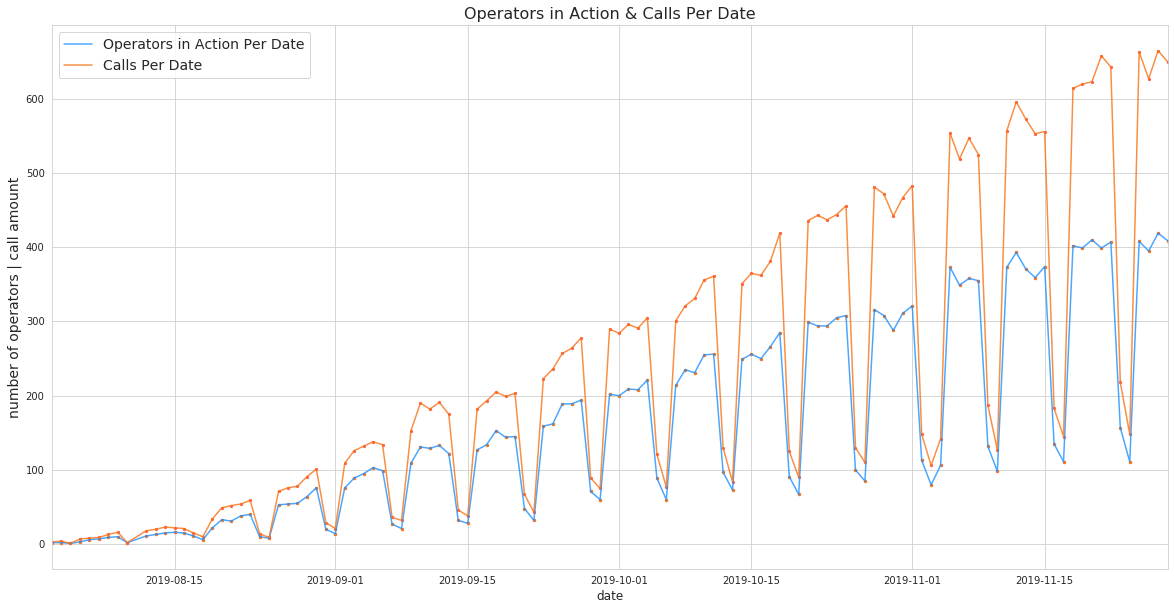

In [147]:
sns.set_style('whitegrid')
plt.figure(figsize=(20,10)) 
plt.scatter(daily['date'],daily['daily'],color='#F87217',s=6)
plt.plot(daily['date'],daily['daily'],color='dodgerblue',label='Operators in Action Per Date',alpha=.8)

plt.scatter(callsperdated['date'],callsperdated['dailycount'],color='tomato',s=5)
plt.plot(callsperdated['date'],callsperdated['dailycount'],color='#F87217',label='Calls Per Date',alpha=.8)

plt.title('Operators in Action & Calls Per Date',fontsize=16)
plt.xlabel('date',fontsize=12)
plt.ylabel('number of operators | call amount',fontsize=14)
plt.xlim("2019-08-02","2019-11-28")
plt.legend(fontsize=14)
plt.show();

In [148]:
#all the dates with a significant drop in call volume & operator action
dropdates=[('2019-08-24','2019-08-25'),('2019-09-01','2019-09-01'),('2019-09-14','2019-09-15'),('2019-09-21','2019-09-22'),(
    '2019-09-28','2019-09-29'),('2019-10-6','2019-10-6'),('2019-10-13','2019-10-13'),('2019-10-20','2019-10-20'),(
    '2019-10-26','2019-10-27'),('2019-11-02','2019-11-04'),('2019-11-09','2019-11-10'),('2019-11-16','2019-11-17'),(
    '2019-11-23','2019-11-24')]

In [149]:
#dates with high call volume & operator action, near drop dates
highdates=[('2019-09-18','2019-09-18'),('2019-09-27','2019-09-27'),(
    '2019-10-11','2019-10-11'),('2019-10-18','2019-10-18'),('2019-10-25','2019-10-25'),(
    '2019-11-05','2019-11-05'),('2019-11-12','2019-11-12'),('2019-11-21','2019-11-21'),(
    '2019-11-25','2019-11-25'),('2019-11-27','2019-11-27')]

In [150]:
#creating a list of arrays of operator ids with activity on the highdates
highop_table = []
for date1, date2 in highdates:
    highop=callsl[callsl.date.between(date1,date2)]['operator_id'].unique()
    highop_table.append(highop)

In [152]:
#seeking common elements in the arrays 
def commonElements(arr):  
      
    # forming a set from 1st array 
    comm = set(arr[0])  
  
    # iterate through all the arrays, finding common values
    for currSet in arr[1:]:  
        comm.intersection_update(currSet)  
  
    return list(comm)  

In [153]:
#distinct operators with activity on every single high date
commonhigh = commonElements(highop_table) 

if len(commonhigh) > 0:  
    print ("Common Element = ",commonhigh)  
else:  
    print ('No Common Elements Found') 

Common Element =  [900352.0, 899082.0, 905104.0, 891410.0, 891154.0, 891414.0, 891416.0, 880026.0, 889754.0, 880028.0, 908958.0, 908960.0, 890402.0, 911138.0, 890404.0, 907174.0, 890416.0, 907952.0, 906296.0, 894656.0, 889410.0, 905538.0, 905542.0, 912722.0, 891988.0, 903254.0, 907224.0, 893402.0, 900826.0, 905564.0, 905566.0, 887276.0, 893804.0, 885876.0, 905844.0, 901880.0, 901884.0]


In [186]:
#a list of common operators on active days to compare to operator performance categories    
highres = list(reduce(lambda i, j: i & j, (set(n) for n in highop_table)))

In [171]:
commonhighopsalldates_inbest = [x for x in bestops if x in highres]
print("These top-rated operators worked every single active date near low-volume dates:",commonhighopsalldates_inbest)
commonhighopsalldates_inbad=[x for x in extremelybadops if x in highres]
print("These worst-rated operators worked every single active date near low-volume dates:",commonhighopsalldates_inbad)

These top-rated operators worked every single active date near low-volume dates: [901884.0, 907224.0]
These worst-rated operators worked every single active date near low-volume dates: [893804.0, 899082.0, 907174.0]


In [172]:
#operators active on high volume days who are in the super-efficient-rated operator group
highop_table_in_bestops=[]
for i in range(len(highop_table)):
    highbest=set(highop_table[i]).intersection(bestarray)
    highop_table_in_bestops.append(highbest)

In [173]:
highoptablebestops=pd.DataFrame(highop_table_in_bestops)
highdates_bestops=highoptablebestops.T

In [174]:
highdates_bestops.columns=('9-18'),('9-27'),('10-11'),('10-18'),('10-25'),(
    '11-05'),('11-12'),('11-21'),('11-25'),('11-27')

In [166]:
highdates_bestops.count().sum()

201

In [175]:
highoptabledf=pd.DataFrame(highop_table)
highoptablelist=highoptabledf.stack().dropna()

In [176]:
highdateoperatorlist=highoptablelist.unique()
print('There are',len(highdateoperatorlist),'operators on dates with the highest call volume.')

There are 825 operators on dates with the highest call volume.


In [169]:
highdatebestopslist=highdates_bestops.stack().dropna()

In [178]:
bestoperators_highdates=highdatebestopslist.unique()
print('There are',len(bestoperators_highdates),"super efficient operators on dates with high call volume and they are:\n",bestoperators_highdates)

There are 47 super efficient operators on dates with high call volume and they are:
 [907970. 917856. 903318. 930692. 940438. 958470. 907224. 907182. 932088.
 901038. 940460. 966158. 905930. 887278. 935348. 907982. 922114. 908082.
 906294. 966686. 901884. 906416. 897872. 935216. 907964. 900790. 910926.
 922428. 917846. 923250. 930510. 924370. 951492. 929626. 918390. 943066.
 958672. 939236. 930910. 888540. 939376. 900594. 958434. 922474. 890232.
 930524. 923254.]


In [184]:
print('Super efficient operators for high call volume comprise this share of high call date operators:')
print('{:,.3%}'.format(len(bestoperators_highdates)/len(highdateoperatorlist)))
print('Which is nearly identical to their share of operators in general:')
print('{:,.3%}'.format(len(bestops)/callsl.operator_id.nunique()))

Super efficient operators for high call volume comprise this share of high call date operators:
5.697%
Which is nearly identical to their share of operators in general:
5.955%


In [50]:
highdates_bestops.agg(['nunique'])

,9-18,9-27,10-11,10-18,10-25,11-05,11-12,11-21,11-25,11-27
nunique,10,10,14,19,20,23,27,29,22,27


In [102]:
#FIND HOW MANY CALLS per OP DO THE ABOVE OPS DO
#How are they classified
#There are 7 ops who are in all dates for high and for low. 

In [187]:
#operators active on high volume days who are in inefficient category
highop_table_in_badops=[]
for i in range(len(highop_table)):
    highb=set(highop_table[i]).intersection(extremelybadopsarray)
    highop_table_in_badops.append(highb)

In [188]:
highoptablebadops=pd.DataFrame(highop_table_in_badops)
highdates_badops=highoptablebadops.T

In [189]:
highdates_badops.columns=('9-18'),('9-27'),('10-11'),('10-18'),('10-25'),(
    '11-05'),('11-12'),('11-21'),('11-25'),('11-27')

In [190]:
highdates_badops.count().sum()

331

In [191]:
highdates_badopslist=highdates_badops.stack().dropna()

In [193]:
badoperators_highdates=highdates_badopslist.unique()
print('There are',len(badoperators_highdates),"inefficient operators on dates with high call volume and they are:\n",badoperators_highdates)

There are 99 inefficient operators on dates with high call volume and they are:
 [898560. 902720. 882690. 937984. 931458. 885890. 937988. 923526. 907174.
 956292. 923528. 913886. 911142. 930690. 937736. 901350. 899082. 904200.
 893804. 900492. 894224. 938896. 904016. 928142. 944908. 937874. 967310.
 896018. 915614. 947604. 899250. 919956. 940952. 913868. 884408. 918956.
 937762. 894230. 954650. 910958. 934188. 937366. 941844. 937902. 934424.
 900180. 946988. 961064. 905300. 925106. 894232. 934098. 937780. 906392.
 934076. 898558. 921818. 936382. 947638. 925922. 947642. 972460. 918888.
 940616. 944564. 964666. 934476. 941390. 944560. 948284. 933996. 933070.
 940614. 968368. 917234. 937808. 939212. 924662. 884946. 954318. 940622.
 908152. 937810. 939224. 940634. 953940. 944474. 921320. 937966. 940652.
 940512. 884478. 951650. 892530. 953464. 933244. 911102. 950634. 890226.]


In [195]:
print('Inefficient operators for high call volume comprise this share of operators:')
print('{:,.1%}'.format(len(badoperators_highdates)/len(highdateoperatorlist)))
print('Which is less than their share of operators in general:')
print('{:,.3%}'.format(len(extremelybadops)/callsl.operator_id.nunique()))

Inefficient operators for high call volume comprise this share of operators:
12.0%
Which is less than their share of operators in general:
16.446%


In [54]:
#unique operators categorized as most inefficient on high volume dates
highdates_badops.agg(['nunique'])

,9-18,9-27,10-11,10-18,10-25,11-05,11-12,11-21,11-25,11-27
nunique,18,11,25,35,38,41,38,43,38,44


In [55]:
highdates_bestops.agg(['nunique'])

,9-18,9-27,10-11,10-18,10-25,11-05,11-12,11-21,11-25,11-27
nunique,10,10,14,19,20,23,27,29,22,27


In [225]:
#creating a list of arrays of operator ids with activity on the dropdates (the extremely low call volume dates)
op_table = []

for date1, date2 in dropdates:
    addop=callsl[callsl.date.between(date1,date2)]['operator_id'].unique()
    op_table.append(addop)
    
len(op_table)    

13

In [11]:
#noting how relatively short the first two arrays are
len(op_table[0]),len(op_table[1]),len(op_table[2])

(13, 14, 43)

In [226]:
#eliminating the first two, short arrays of operators
op_table = op_table[2:]
#creating arrays for just Oct/Nov
op_table8 = op_table[5:]
len(op_table)

11

In [200]:
#running function to list common operators between all arrays of the active operators on slow dates
common = commonElements(op_table)  
if len(common) > 0:  
    print ("Common Element = ",common)  
else:  
    print ('No Common Elements Found') 

No Common Elements Found


In [201]:
#running function to list common operators between the arrays of the active operators on slow dates Oct/Nov
common8 = commonElements(op_table8)  
if len(common8) > 0:  
    print ("Common Element = ",common8)  
else:  
    print ('No Common Elements Found') 

Common Element =  [919552.0, 919554.0, 914052.0, 923526.0, 923528.0, 938896.0, 929424.0, 924948.0, 924950.0, 896536.0, 900892.0, 908958.0, 924960.0, 925104.0, 899250.0, 906680.0, 909134.0, 913788.0, 903254.0, 900826.0, 893402.0, 921818.0, 921306.0, 915556.0, 932836.0, 904038.0, 937956.0, 937958.0, 937960.0, 937962.0, 893420.0, 893804.0, 919790.0, 919792.0, 905842.0, 918390.0, 901880.0, 901884.0]


In [202]:
#lambda functions to doublecheck having found the common elements within
res = list(reduce(lambda i, j: i & j, (set(n) for n in op_table)))
res8 = list(reduce(lambda i, j: i & j, (set(n) for n in op_table8)))
# Result
print("The common elements among inners lists : ",res,"\n")

print("The common elements among inners lists for October and November:",res8)

The common elements among inners lists :  [] 

The common elements among inners lists for October and November: [919552.0, 919554.0, 914052.0, 923526.0, 923528.0, 938896.0, 929424.0, 924948.0, 924950.0, 896536.0, 900892.0, 908958.0, 924960.0, 925104.0, 899250.0, 906680.0, 909134.0, 913788.0, 903254.0, 893402.0, 900826.0, 921818.0, 921306.0, 915556.0, 932836.0, 904038.0, 937958.0, 937956.0, 937960.0, 937962.0, 893420.0, 893804.0, 919790.0, 919792.0, 905842.0, 918390.0, 901880.0, 901884.0]


In [204]:
#operators active on every drop date in Oct/Nov who are categorized as super efficient
commonops8dates_inbest = [x for x in bestops if x in res8]
commonops8dates_inbest

[901884.0, 918390.0]

In [206]:
#operators active on every drop date in Oct/Nov who are categorized as inefficient
commonops8dates_inbad = [x for x in extremelybadops if x in res8]
commonops8dates_inbad

[893804.0, 899250.0, 921818.0, 923526.0, 923528.0, 938896.0]

In [207]:
#active on all high volume days and all low volume days 
[x for x in commonhigh if x in common]
#doublecheck: active on all high volume days and all low volume days 
[x for x in common if x in commonhigh]

[]

In [209]:
#active on all high volume days and all Oct/Nov low volume days   
extensivelist=[x for x in commonhigh if x in common8]
#active on all high volume days and all Oct/Nov low volume days  
[x for x in common8 if x in commonhigh]

[908958.0, 903254.0, 900826.0, 893402.0, 893804.0, 901880.0, 901884.0]

In [210]:
[x for x in extensivelist if x in extremelybadops]

[893804.0]

In [211]:
[x for x in extensivelist if x in bestops]

[901884.0]

In [212]:
#operators on low volume call dates who are categorized as super efficient
op_table_in_bestops=[]
for i in range(len(op_table)):
    nextx=set(op_table[i]).intersection(bestarray)
    op_table_in_bestops.append(nextx)

In [229]:
dfoptablebestops=pd.DataFrame(op_table_in_bestops)
dropdates_bestops=dfoptablebestops.T

In [231]:
dropdates_bestops.columns=('8-24-25'),('9-1'),('9-14-15'),('9-21-22'),(
    '9-28-29'),('10-6'),('10-13'),('10-20'),('10-26-27'),('11-02-04'),('11-09-10'),('11-16-17'),('11-23-24')

In [232]:
dropdates_bestops.count().sum()

57

In [233]:
optabledf=pd.DataFrame(op_table)
optablelist=optabledf.stack().dropna()

In [234]:
dropdateoperatorlist=optablelist.unique()
print('There are',len(dropdateoperatorlist),'operators on dates with relative low call value.')

There are 398 operators on dates with relative low call value.


In [239]:
dropdatebestopslist=dropdates_bestops.stack().dropna()

In [238]:
bestoperators_dropdates=dropdatebestopslist.unique()
print('There are',len(bestoperators_dropdates),"super efficient operators on dates with relatively low calls and they are:\n",bestoperators_dropdates)

There are 21 super efficient operators on dates with relatively low calls and they are:
 [890232. 901884. 910902. 918390. 923250. 935216. 922428. 943066. 969600.
 891192. 910926. 903318. 939376. 901038. 957922. 922474. 930524. 900594.
 940460. 929626. 935348.]


In [85]:
print('Super efficient operators on the lowest call volume days comprise this share of operators:')
print('{:,.3%}'.format(len(bestoperators_dropdates)/len(dropdateoperatorlist)))

Super efficient operators on the lowest call volume days comprise this share of operators:
5.025%


In [122]:
#on each low call date, there are this many unique operators
dropdates_bestops.agg(['nunique'])

,9-14-15,9-21-22,9-28-29,10-6,10-13,10-20,10-26-27,11-02-04,11-09-10,11-16-17,11-23-24
nunique,4,2,4,3,3,4,5,8,7,4,11


In [240]:
set(bestops).intersection(*op_table)

{901884.0}

In [241]:
#operators on low volume call dates who are categorized as inefficient
op_table_in_badops=[]
for i in range(len(op_table)):
    nextb=set(op_table[i]).intersection(extremelybadopsarray)
    op_table_in_badops.append(nextb)

In [242]:
dfoptablebadops=pd.DataFrame(op_table_in_badops)
dropdates_badops=dfoptablebadops.T

In [243]:
dropdates_badops.count().sum()

153

In [244]:
dropdatebadopslist=dropdates_badops.stack().dropna()

In [246]:
badoperators_dropdates=dropdatebadopslist.unique()
print('There are',len(badoperators_dropdates),"inefficient operators on dates with relatively low calls and they are:\n",badoperators_dropdates)

There are 50 inefficient operators on dates with relatively low calls and they are:
 [885890. 902720. 937984. 931458. 923526. 882690. 899082. 908098. 917378.
 925922. 937762. 940614. 893804. 908162. 923528. 952196. 900492. 901350.
 918956. 921320. 940616. 895598. 938896. 910958. 928382. 954650. 884946.
 899250. 925106. 891918. 946468. 940952. 905300. 884408. 906392. 921818.
 939212. 911102. 914172. 891646. 940622. 900180. 940652. 940634. 937810.
 950634. 934076. 917234. 964712. 953464.]


In [247]:
print('Infficient operators on the lowest call volume days comprise this share of operators:')
print('{:,.3%}'.format(len(badoperators_dropdates)/len(dropdateoperatorlist)))

Infficient operators on the lowest call volume days comprise this share of operators:
12.563%


In [36]:
dropdates_badops.agg(['nunique'])

,0,1,2,3,4,5,6,7,8
nunique,9,10,9,12,11,18,20,18,25


In [271]:
metrics.calls_per_op.quantile([.92,.93,.95])

0.92    112.72
0.93    120.63
0.95    139.45
Name: calls_per_op, dtype: float64

In [253]:
metrics.calls_per_op.nlargest(3)

204    323
203    302
108    289
Name: calls_per_op, dtype: int64

In [249]:
metrics[metrics.operator_id==901884]

,operator_id,wait_total,missed_total,calls_per_op,total_duration,wait_share,miss_share,out_share,wait,miss,out,total,score,segment,tier
204,901884.0,38994,104,323,335615,0.116187,0.321981,0.705882,4,3,3,10.0,super efficient,433,Super efficient


In [250]:
metrics[metrics.operator_id==893804]

,operator_id,wait_total,missed_total,calls_per_op,total_duration,wait_share,miss_share,out_share,wait,miss,out,total,score,segment,tier
108,893804.0,76146,110,289,358580,0.212354,0.380623,0.629758,2,2,2,6.0,inefficient,222,Inefficient


In [263]:
metrics[metrics.operator_id==893402]

,operator_id,wait_total,missed_total,calls_per_op,total_duration,wait_share,miss_share,out_share,wait,miss,out,total,score,segment,tier
104,893402.0,6490,15,117,38141,0.170158,0.128205,0.299145,3,4,2,9.0,efficient,342,Efficient


In [264]:
metrics[metrics.operator_id==908958]

,operator_id,wait_total,missed_total,calls_per_op,total_duration,wait_share,miss_share,out_share,wait,miss,out,total,score,segment,tier
320,908958.0,27131,29,143,136908,0.19817,0.202797,0.342657,3,3,2,8.0,efficient,332,Efficient


In [265]:
metrics[metrics.operator_id==900826]

,operator_id,wait_total,missed_total,calls_per_op,total_duration,wait_share,miss_share,out_share,wait,miss,out,total,score,segment,tier
190,900826.0,11256,48,165,65297,0.172382,0.290909,0.721212,3,3,3,9.0,efficient,333,Efficient


In [266]:
metrics[metrics.operator_id==903254]

,operator_id,wait_total,missed_total,calls_per_op,total_duration,wait_share,miss_share,out_share,wait,miss,out,total,score,segment,tier
224,903254.0,29341,71,221,133294,0.220122,0.321267,0.687783,2,3,3,8.0,efficient,233,Waiting: Danger


In [262]:
metrics[metrics.calls_per_op>283]

,operator_id,wait_total,missed_total,calls_per_op,total_duration,wait_share,miss_share,out_share,wait,miss,out,total,score,segment,tier
108,893804.0,76146,110,289,358580,0.212354,0.380623,0.629758,2,2,2,6.0,inefficient,222,Inefficient
203,901880.0,50377,111,302,482797,0.104344,0.367550,0.642384,4,2,2,8.0,efficient,422,Inefficient but engaged
204,901884.0,38994,104,323,335615,0.116187,0.321981,0.705882,4,3,3,10.0,super efficient,433,Super efficient


<font color='tomato'><h3>Active Operators</h3></font>
<p style="font-size:17px"><br>
There are not a tremendous amount of commonalities among the half dozen operators who are active on each and every high volume day and all October/November low volume days....except for one metric.<br>
They are all above the 92% quartile of calls per operator and all but one are above 95%.<br>
In fact, the three operators with the top-most calls per operator count are all in the selective group of those active on all these dates.<br>
<br> Other than the single super efficient operator, half were tiered efficient (all were scored efficient, except one) and the rest were tiered inefficient or in danger. Their wait share ranged from about 11% to double that and their missed share ranged from 13% to triple that. Their outgoing share ranged from a third to more than two-thirds, though most had the latter.

<font color='crimson'><h3>Analysis of Dates</h3></font><p style="font-size:17px">
This look at dates started off with a super efficient operator list that is 36% the length of the inefficient operator list. The reason for this disparity is that each list included only those operators who were both scored and tiered as super efficient, or inefficient, as the case may be...and the latter started off with a far greater pool to draw from.
    <p style="font-size:17px">
Inefficient operators slightly increased their representation on the lowest call volume days and the best operators slightly decreased their representation on those days. The opposite is true for the heaviest call volume days.
<p style="font-size:17px">
On the lowest call volume days, inefficient operators comprised 12.56% of active operators and super efficient operators were 
5.025%. On high call volume days, inefficient operators dropped to 12% of the share of active operators, which is 73% of their usual representation in general. Super efficient operators are 5.697% of operators on high call volume days, which is 96% of their usual representation among operators.

<font color='tomato'><h3>Bottom Line on Dates</h3></font><p style="font-size:17px">
There is no clearcut explanation why, like clockwork, the low-call count days appear on such a regular basis. For this business, it is clearly a critical matter, especially as the numbers plummet relatively greater amounts each time.
<p style="font-size:17px">
There are two possible ways to consider the dates: the low-call count days reflect the ineptitude of inefficient operators OR the operators handling calls on the low-call count days, especially those who are handling calls on each and every one of the low-call count days, are actually showing extreme efficiency to be handling calls when the vast majority of operators are noticeably absent. 
<p style="font-size:17px">
While the drop dates overlap weekends, that timing alone does not entirely explain the deleterious impact wrought upon this virtual telephony operator handling calls for businesses operating in this era. The reason that call volume would not have that dramatic decline on a weekend in 2019 is that the lion's share of businesses have ample weekend communication and work. Any virtual telephony provider with this call volume would necessarily be handling communications traffic for either one very broad-ranging corporate entity or multiple companies.  And nowadays, with mobile communication and globalization, that encompasses weekend work.
<p style="font-size:17px">
For example, according to Forbes, a 2017 survey found that 70% worked at least one weekend a month, with 63% saying that their employer expected them to put in time on an average Saturday and Sunday. More than 35 percent of employed Americans work on an average weekend day, according to the Bureau of Labor Statistics American Time Use Survey. 51 percent of people with multiple jobs were likely to work on an average weekend day.  
<p style="font-size:17px">
So, although it is easy to impute the erratic call volume to weekend off-time alone, that does not reflect business reality and corporate telephony needs in this era.

<div class="info">
<font color='#461B7E' font size=3>
    Pivot tables for scored and segmented data</div>

In [77]:
val=['calls_per_op','wait_total','missed_total','miss_share','wait_share','out_share','total_duration']
pivot2 = metrics.pivot_table(values=val, columns='tier', aggfunc=lambda x: round(x.mean(),3)).reset_index()
pivot2t=pd.DataFrame(pivot2).T.reset_index()
pivot2t.columns=['tier','calls_per_op','miss_share','missed_total','out_share','total_duration','wait_share','wait_total']
pivot2t=pivot2t[1:]
pivot2t

,tier,calls_per_op,miss_share,missed_total,out_share,total_duration,wait_share,wait_total
1,Efficient,61.85,0.264,17.02,0.67,28130.4,0.169,4834.9
2,Efficient incoming,19.082,0.05,1.213,0.043,9801.89,0.157,973.426
3,Inefficient,31.405,0.307,12.012,0.533,74688.7,0.356,20168.2
4,Inefficient but engaged,45.156,0.435,19.215,0.918,73269.6,0.163,9569.35
5,Inefficient outgoing,19.194,0.631,9.876,1,45033.9,0.612,20780.1
6,Missing: Danger,75.079,0.39,28.724,0.795,61083.3,0.172,10674.1
7,Super efficent incoming,13.89,0.016,0.438,0.018,7293.4,0.08,478.685
8,Super efficient,47.354,0.205,12.08,0.691,33142.8,0.087,3229.25
9,Waiting: Danger,43,0.264,12.306,0.58,27832.6,0.266,7119.17


In [38]:
vala=['calls_per_op','miss_share','wait_share','total_duration','call_duration']
pivot3 = metricsforchart.pivot_table(values=vala, columns='tier', aggfunc=lambda x: round(x.mean(),2)).reset_index()
pivot3t=pd.DataFrame(pivot3).T.reset_index()
pivot3t.columns=['tier','call_duration','calls_per_op','miss_share','total_duration','wait_share']
pivot3t=pivot3t[1:]
pivot3t

,tier,call_duration,calls_per_op,miss_share,total_duration,wait_share
1,Efficient,23295.5,61.85,0.26,28130.4,0.17
2,Efficient incoming,8828.46,19.08,0.05,9801.89,0.16
3,Inefficient,54520.6,31.41,0.31,74688.7,0.36
4,Inefficient but engaged,63700.3,45.16,0.44,73269.6,0.16
5,Inefficient outgoing,24253.8,19.19,0.63,45033.9,0.61
6,Missing: Danger,50409.2,75.08,0.39,61083.3,0.17
7,Super efficent incoming,6814.71,13.89,0.02,7293.4,0.08
8,Super efficient,29913.5,47.35,0.2,33142.8,0.09
9,Waiting: Danger,20713.4,43,0.26,27832.6,0.27


In [30]:
metricsforchart=metrics
metricsforchart['call_duration']=metrics.total_duration-metrics.wait_total
metricsslim=metricsforchart.drop(['wait_total', 'missed_total','total_duration','miss','out','total','wait_share', 'miss_share', 'out_share', 'wait', 'segment','call_duration'],axis=1)

In [35]:
metricswithdate=datedf.merge(metricsslim, on='operator_id',how='left')
metricswithdate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27436 entries, 0 to 27435
Data columns (total 6 columns):
date            27436 non-null datetime64[ns]
operator_id     27436 non-null float64
wait            27436 non-null int64
calls_per_op    27436 non-null int64
score           27436 non-null object
tier            27436 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 1.5+ MB


In [37]:
metricswithmissed=datemissed.merge(metricsslim, on='operator_id',how='left')
metricswithmissed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14110 entries, 0 to 14109
Data columns (total 5 columns):
date            14110 non-null datetime64[ns]
operator_id     14110 non-null float64
calls_per_op    14110 non-null int64
score           14110 non-null object
tier            14110 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 661.4+ KB


In [36]:
scoretierchart=metricsforchart.drop(['wait_total', 'missed_total','calls_per_op','total_duration','wait_share', 'miss_share', 'out_share','call_duration'],axis=1)

In [41]:
valout=['calls_per_op','out_share','call_duration','total_duration']
pivotout = metricsforchart.pivot_table(values=valout, columns='score',aggfunc=lambda x: round(x.mean(),2)).reset_index()
pivotout

pivotout=pd.DataFrame(pivotout).T.reset_index()
pivotout.columns=['score','call_duration','calls_per_op','out_share','total_duration']
pivotout=pivotout[1:]
pivotout

,score,call_duration,calls_per_op,out_share,total_duration
1,danger zone,58770.3,38.96,0.65,78490.5
2,efficient,34166,45.74,0.56,39847.8
3,inefficient,34997.1,24.61,0.62,54184.8
4,super efficient,21730.6,38.01,0.89,23836.6


In [42]:
valall=['calls_per_op','miss_share','wait_share','call_duration','total_duration']
pivot5 = metricsforchart.pivot_table(values=valall, columns='score',aggfunc=lambda x: round(x.mean(),2)).reset_index()
pivot5t=pd.DataFrame(pivot5).T.reset_index()
pivot5t.columns=['score','call_duration','calls_per_op','miss_share','total_duration','wait_share']
pivot5t=pivot5t[1:]
pivot5t

,score,call_duration,calls_per_op,miss_share,total_duration,wait_share
1,danger zone,58770.3,38.96,0.34,78490.5,0.28
2,efficient,34166,45.74,0.26,39847.8,0.15
3,inefficient,34997.1,24.61,0.42,54184.8,0.51
4,super efficient,21730.6,38.01,0.23,23836.6,0.1


In [59]:
metricsout['wait'] = pd.qcut(metricsout.wait_share, q = 4, labels = w_labels)
metricsout['miss'] = pd.qcut(metricsout.miss_share, q = 4, labels = m_labels)
metricsout['out'] = pd.cut(metricsout.out_share, bins=out_share_bin, labels = o_labels)
metricsout['total']=metricsout[['wait','miss','out']].sum(axis=1)
metricsout['score']=metricsout['total'].apply(score)
metricsout['call_duration']=metricsout.total_duration-metricsout.wait_total
colout=['outgoing_total','calls_per_op','out_share','call_duration','total_duration']
pivotoutotal = metricsout.pivot_table(values=colout, columns='score',aggfunc=lambda x: round(x.mean(),2)).reset_index()

In [60]:
pivotoutotal=pd.DataFrame(pivotoutotal).T.reset_index()
pivotoutotal.columns=['score','call_duration','calls_per_op','out_share','outgoing_total','total_duration']
pivotoutotal=pivotoutotal[1:]
pivotoutotal

,score,call_duration,calls_per_op,out_share,outgoing_total,total_duration
1,danger zone,58770.3,38.96,0.65,27.62,78490.5
2,efficient,34166,45.74,0.56,29.92,39847.8
3,inefficient,34997.1,24.61,0.62,17.79,54184.8
4,super efficient,21730.6,38.01,0.89,31.55,23836.6


<font color='crimson'><h3>Overall Conclusion</h3></font><p style="font-size:17px">
<p style="font-size:17px">
In this analysis, in the most apt scoring method, 47.5%, or 517, operators are inefficient or in the danger zone.
<p style="font-size:17px">
That number is parallel to the amount of operators whose call count is less than 19 over the course of a quarter of a year!
Inefficient scored operators have 54% of the calls per operator that efficient scored operators have. But those in the danger zone and super efficient scored operators have equivalent amounts of calls per operator. 
<p style="font-size:17px">
Much of the cause of inefficiency for these operators, such as the dramatic drop in calls for a day or two every single week, does not have a clear cut explanation.  It is possible to single out the operators who post the highest amount of calls, paired with the lowest miss rate, the highest outgoing rate and the lowest wait time, but even among the operators who successfully handle calls on days that few operators do, their metrics are not across-the-board stellar nor are their scores.
<p style="font-size:17px">
The scoring method notes 99 super efficient operators, two-thirds of which lead the tier segmentation scheme as well. Their low shares for wait and missed calls coupled with the high share of outgoing calls serve as the model behavior for operators.
<p style="font-size:17px">
The tiered ranking segments inefficient operators who primarily handle outgoing calls and those who have the one of the lowest possible scores for waiting or missed calls, but nonetheless have high scores for the other metrics. So those inefficient operators have potential that needs to be augmented by improved performance in the key missed and wait metrics. By highlighting the inefficient operators' assets and pinpointing the metrics by which they are failing, it is possible to focus on the skills to be improved and those that must be maintained.
<p style="font-size:17px">
The company must attend to the pressing and growing problem of the weekly drop in calls. When attention is focused on those dates, it will also give the company an opportunity to invest more call capacity in the operators lagging in call count, which in turn might enable them to post further across-the-board improvements. 

<font color='deepskyblue'><h3>Some Industry Sources</h3></font><p style="font-size:17px">
<br>
[How long do callers wait before they hang up?](https://www.talkdesk.com/blog/how-long-do-callers-wait-before-they-hang-up/)<br>
[Average waiting time aka average speed of answer](https://oneview.mitel.com/s/article/Average-Waiting-Time-a-k-a-Average-Speed-of-Answer-ASA)<br>
[How big data & analytics can drive profitability for telecom operators](https://medium.com/@exastax/how-big-data-and-analytics-can-drive-profitability-for-telecom-operators-b47827bfad7c)<br>
[Industry average acceptable wait time](https://www.callcentrehelper.com/forum/industry-average-acceptable-wait-time-111203.htm)<br>
[Missed calls: businesses pay for failing to pick up the phone](https://www.ringover.com/blog/missed-calls-businesses-pay-failing-to-pick-up-the-phone)<br>
[Intentional missed calls](https://en.wikipedia.org/wiki/Missed_call)<br>
[Setting the right ring time](https://talkroute.com/set-the-perfect-ring-time-for-your-office-phones/)<br><br>